In [1]:
!date

Wed Feb  5 22:42:48 PST 2020


In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from scipy import stats
from scipy.optimize import curve_fit
import ast
from scipy.stats import sem
from sklearn.metrics import adjusted_rand_score
from scipy.stats import ks_2samp, ttest_ind
import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
gene = anndata.read_h5ad("cell_ranger_annotation/gene.h5ad")
isoform = anndata.read_h5ad("cell_ranger_annotation/isoform.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [1252]:
isoform.var["idx"] = np.arange(isoform.var.shape[0])

# New t2g

In [3]:
cols = ["transcript_id", "gene_id", "gene_name", "transcript_name", "chromosome", "start", "stop", "strand"]
t2g = pd.read_csv("/home/sina/projects/mop/reference/cellranger_index/refdata-cellranger-mm10-3.0.0/kb_out/t2g.txt", sep="\t", header=None, names=cols)

In [4]:
def swap_start(start, stop, strand):
    new_start = start
    new_stop = stop
    if strand=="-":
        new_start = stop
        new_stop = start
    return new_start, new_stop

In [5]:
tmp = t2g.apply(lambda x: swap_start(x["start"], x["stop"], x["strand"]), axis=1).tolist()
t2g[["new_start", "new_stop"]] = pd.DataFrame(tmp, columns=["new_start", "new_stop"])

# Group isoforms by (1) Gene and then (2) Transcripton start sites

In [951]:
gb = t2g.groupby(["chromosome", "gene_name", "new_start"])["transcript_name"].apply(list)
gb = gb.reset_index()
gb = gb.rename(columns={"transcript_name":"tss_same"})
gb["tss_len"] = gb["tss_same"].apply(lambda x: len(x))

In [958]:
gb.tss_len.max()

23

In [960]:
gb["n_tss_same"] = gb["tss_same"].apply(lambda x: len(x))

num_iso_per_gene = t2g.groupby("gene_name")["transcript_name"].count()
max_tss_set_size = gb.groupby("gene_name")["tss_len"].apply(max)
num_tss_with_1_iso = gb.groupby("gene_name")["tss_len"].apply(lambda x: (np.array(x)==1).sum())

gb["n_iso"] = gb["gene_name"].map(num_iso_per_gene)
gb["max_tss_size"] = gb["gene_name"].map(max_tss_set_size)
gb["num_tss_1_iso"] = gb["gene_name"].map(num_tss_with_1_iso)

txn_list = gb["tss_same"].explode().values

#gb["tss_same"] = gb.tss_same.astype(str)
gb["tss_class"] = np.arange(gb.shape[0])

In [9]:
#gb.to_csv( "cell_ranger_annotation/t2g_grouped.csv")

In [961]:
## Conditions
# 1. n_iso per gene > 2
# 2. 2< n_TSS_same < n_iso

# mask = np.logical_and(gb["n_tss_same"].values >2, np.logical_and(gb["n_iso"]>2, gb["n_tss_same"].values < gb["n_iso"]))
mask = np.logical_and(gb["max_tss_size"]>1, np.logical_and(gb["n_iso"] > 2, gb["n_tss_same"] < gb["n_iso"]))

ft2g = gb[mask]

In [ ]:
# remove the tss classes where a single isoform has been discarded
ft2g["filter"] = ft2g.tss_same.apply(lambda x: np.array([i not in isoform.var.index.values for i in x]).sum())
ft2g = ft2g[ft2g["filter"]==0]

In [1190]:
dtss_tname = ft2g["tss_same"].to_dict()

In [1191]:
l = list(dtss_tname.values())

In [1192]:
flatten = lambda l: [item for sublist in l for item in sublist]
lf = flatten(l)

In [1193]:
tmp_iso = isoform[:, isoform.var.transcript_name.isin(lf)]
tmp_iso

View of AnnData object with n_obs × n_vars = 6043 × 29963 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_TPM', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'gene_TPM', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'idx'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p'

In [1194]:
def invert_dict(d): 
    inverse = dict() 
    for key in d: 
        # Go through the list that is saved in the dict:
        for item in d[key]:
            # Check if in the inverted dict the key exists
            if item not in inverse: 
                # If not create a new entry
                inverse[item] = key
    return inverse

In [1195]:
dtname_tss = invert_dict(dtss_tname)

In [1196]:
tmp_iso.var["tss_class"] = tmp_iso.var.index.map(dtname_tss)

Trying to set attribute `.var` of view, copying.


In [1200]:
tmp_iso

AnnData object with n_obs × n_vars = 6043 × 29963 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_TPM', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'gene_TPM', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'idx', 'tss_class'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p'

In [1201]:
tmp_iso.var["tss_class"]

Mrpl15-203     3605
Mrpl15-206     3606
Mrpl15-201     3604
Mrpl15-202     3606
Mrpl15-207     3602
              ...  
Fam45a-206    44031
Fam45a-207    44032
Fam45a-201    44032
Fam45a-204    44033
Fam45a-205    44034
Name: tss_class, Length: 29963, dtype: int64

In [1202]:
tmp_iso.var.tss_class.map(ft2g["tss_same"]).explode()

Mrpl15-203    Mrpl15-203
Mrpl15-206    Mrpl15-206
Mrpl15-206    Mrpl15-202
Mrpl15-206    Mrpl15-205
Mrpl15-201    Mrpl15-201
                 ...    
Fam45a-207    Fam45a-201
Fam45a-201    Fam45a-207
Fam45a-201    Fam45a-201
Fam45a-204    Fam45a-204
Fam45a-205    Fam45a-205
Name: tss_class, Length: 43139, dtype: object

In [1204]:
(~ft2g[ft2g["tss_class"].isin(tmp_iso.var["tss_class"])]["tss_same"].explode().isin(isoform.var.index)).sum()

0

In [1205]:
def sum_tss_same(mtx, components, features):
    
    unique = np.unique(features)
    nuniq = unique.shape[0]
    ncomp = components.shape[0]
    
    s_mtx = np.zeros((ncomp, nuniq))
    
    for uidx, u in enumerate(unique):
        mask = features == u
        s_mtx[:,uidx] = np.asarray(mtx[:,mask].sum(axis=1)).reshape(-1)
    
    return s_mtx, unique

In [1210]:
# sum the isoforms with the same start site
features = tmp_iso.var.tss_class.values
components = tmp_iso.obs.cell_id.values
mtx = tmp_iso.layers["X"].todense()
# sum the raw counts then normalize and log?

mtx, unique = sum_tss_same(mtx, components, features)

In [1211]:
X = mtx
obs = isoform.obs

In [1212]:
(~ft2g.loc[tmp_iso.var["tss_class"]]["tss_same"].explode().isin(isoform.var.index)).sum()

0

In [1213]:
var = ft2g.loc[unique]

In [1259]:
var["idx"] = np.arange(var.shape[0])

In [1271]:
stss = anndata.AnnData(X=X, obs=obs, var=var)
stss.var.index = stss.var.index.astype(int)

Transforming to str index.


In [1355]:
tss = stss.var.index.values
txn = tmp_iso.var.index.values

tss_idx = np.arange(len(tss))
txn_idx = np.arange(len(txn))
tss_n_same = stss.var.n_tss_same

dtss_idx = dict(zip(tss, tss_idx))
dtss_n_same = dict(zip(tss, tss_n_same))

In [1354]:
stss.var

,chromosome,gene_name,new_start,tss_same,tss_len,n_tss_same,n_iso,max_tss_size,num_tss_1_iso,tss_class,filter,idx
87,1,2310035C23Rik,105663861,"[2310035C23Rik-208, 2310035C23Rik-205]",2,2,12,2,10,87,0,0
88,1,2310035C23Rik,105663883,[2310035C23Rik-201],1,1,12,2,10,88,0,1
89,1,2310035C23Rik,105663913,[2310035C23Rik-202],1,1,12,2,10,89,0,2
90,1,2310035C23Rik,105663923,[2310035C23Rik-210],1,1,12,2,10,90,0,3
91,1,2310035C23Rik,105663937,[2310035C23Rik-211],1,1,12,2,10,91,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
101796,Y,Eif2s3y,1010543,[Eif2s3y-201],1,1,6,2,4,101796,0,24911
101797,Y,Eif2s3y,1010595,"[Eif2s3y-203, Eif2s3y-205]",2,2,6,2,4,101797,0,24912
101798,Y,Eif2s3y,1010599,[Eif2s3y-206],1,1,6,2,4,101798,0,24913
101799,Y,Eif2s3y,1010624,[Eif2s3y-204],1,1,6,2,4,101799,0,24914


In [1360]:
stss.var["n_tss_same"]

87        2
88        1
89        1
90        1
91        1
         ..
101796    1
101797    2
101798    1
101799    1
101800    1
Name: n_tss_same, Length: 24916, dtype: int64

In [1371]:
np.repeat(p2 ,stss.var["n_tss_same"].values, axis=1).shape

(4, 29963)

In [1373]:
stss.v

(4, 24916)

In [1357]:
i2tss["tss_class_idx"] = i2tss["tss_class"].map(dtss_idx)
i2tss["tss_n_same"] = i2tss["tss_class"].map(dtss_n_same)

# Now log1p them and then perform the ops on that

In [1276]:
stss.layers["X"] = X
scanp.pp.log1p(stss)

In [1277]:
stss.layers["log1p"] = stss.X.copy()

In [1278]:
scanp.pp.scale(stss, max_value=10)

# STSS is an anndata where the TSS transcripts are grouped by start site and summed

In [22]:
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ks_2samp, ttest_ind
import numpy as np
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')



def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def correct_pval(pval, method):
    nfeat = pval.shape[1]
    
    if method == 'benjamini-hochberg':
        _, pval_corr, _, _ = multipletests(pval, alpha=0.05, method='fdr_bh')
    elif method == 'bonferroni':
        pval_corr = np.minimum(pval * nfeat, 1.0)
        
    return pval_corr

def dexpress(mat, components, features, assignments, **kwargs):
    """
    mat: ndarray
    components: nparray
    features: nparray
    assignments: nparray, length is equal to length of components
    """
    nan_cutoff = kwargs.get("nan_cutoff", 0)
    corr_method = kwargs.get("corr_method", "bonferroni")
    
    unique = np.unique(assignments)
        
    ncomp = components.shape[0]
    nfeat = features.shape[0]
    nuniq = unique.shape[0]
    
    pval = np.empty((nuniq, nfeat)) # unique assignments by features 
    pval_corr = np.empty((nuniq, nfeat)) # unique assignments by features 
    stat = np.empty((nuniq, nfeat)) # unique assignments by features 
    
    pval.fill(np.nan)
    pval_corr.fill(np.nan)
    stat.fill(np.nan)

    for tidx, t in enumerate(unique):
        logging.debug("{} of {} assignments: {}".format(tidx+1, nuniq, t))
        t_mat, c_mat = split_by_target(mat, assignments, t, axis=0)

        
        pvalue = np.nan
        statistic = np.nan

        # Keep only the genes for which it is in at least nan_cutoff*ncellsinclusters
        mask = np.asarray((t_mat>0).sum(axis=0) > nan_cutoff*t_mat.shape[0]).reshape(-1)

        # tmp_t_mat = t_mat[:, mask]
        # tmp_c_mat = c_mat[:, mask]
        # added

        bool_list = [True]*t_mat.shape[1]
        stat_mask = np.bool(bool_list)
        # added
        if mask.sum()>0:
            test = ttest_ind(t_mat, c_mat, nan_policy="propagate")
            pvalue = test.pvalue/2
            statistic = test.statistic
            stat_mask = statistic>100 # >0 enrichment, <0 depletion
            
        m = np.logical_and(mask, stat_mask)
        pval[tidx,:][m] = pvalue[m]
        stat[tidx,:][m] = statistic[m]

    pval_corr = correct_pval(pval, corr_method)
    
    return (pval, pval_corr, stat)

In [619]:
def dexpress(mat, components, features, assignments, **kwargs):
    """
    mat: ndarray
    components: nparray
    features: nparray
    assignments: nparray, length is equal to length of components
    """
    nan_cutoff = kwargs.get("nan_cutoff", 0)
    corr_method = kwargs.get("corr_method", "bonferroni")
    
    unique = np.unique(assignments)
        
    ncomp = components.shape[0]
    nfeat = features.shape[0]
    nuniq = unique.shape[0]
    
    pval = np.empty((nuniq, nfeat)) # unique assignments by features 
    pval_corr = np.empty((nuniq, nfeat)) # unique assignments by features 
    stat = np.empty((nuniq, nfeat)) # unique assignments by features 
    
    pval.fill(np.nan)
    pval_corr.fill(np.nan)
    stat.fill(np.nan)

    for tidx, t in enumerate(unique):
        logging.debug("{} of {} assignments: {}".format(tidx+1, nuniq, t))
        t_mat, c_mat = split_by_target(mat, assignments, t, axis=0)

        
        pvalue = np.nan
        statistic = np.nan

        # Keep only the genes for which it is in at least nan_cutoff*ncellsinclusters
        mask = np.asarray((t_mat>0).sum(axis=0) > nan_cutoff*t_mat.shape[0]).reshape(-1)

        t_mat = t_mat[:, mask]
        c_mat = c_mat[:, mask]
        # added

        # added
        if mask.sum()>0:
            test = ttest_ind(t_mat, c_mat, nan_policy="propagate")
            pvalue = test.pvalue
            statistic = test.statistic
                
        pval[tidx,:][mask] = pvalue
        stat[tidx,:][mask] = statistic
    
    return (pval, stat)

In [620]:
%%time
nc = 100
nf = 100

mat         = stss.X[:nc,:nf]
components  = stss.obs.cell_id.values[:nc]
features    = stss.var.tss_class.values[:nf]
assignments = stss.obs.subclass_label.values[:nc]

# %lprun -f dexpress dexpress(mat, components, features, assignments)
pval, stat = dexpress(mat, components, features, assignments, nan_cutoff=0.9)

27-Feb-20 04:21:43 - 1 of 8 assignments: L2/3 IT
27-Feb-20 04:21:43 - 2 of 8 assignments: L5 IT
27-Feb-20 04:21:43 - 3 of 8 assignments: L5/6 NP
27-Feb-20 04:21:43 - 4 of 8 assignments: L6 IT
27-Feb-20 04:21:43 - 5 of 8 assignments: Lamp5
27-Feb-20 04:21:43 - 6 of 8 assignments: Pvalb
27-Feb-20 04:21:43 - 7 of 8 assignments: Sst
27-Feb-20 04:21:43 - 8 of 8 assignments: Vip


CPU times: user 13 ms, sys: 3.71 ms, total: 16.7 ms
Wall time: 13.3 ms


In [537]:
(~np.isnan(pval_corr)).sum()

15

In [1374]:
%%time

mat         = stss.layers["log1p"]
components  = stss.obs.cell_id.values
features    = stss.var.tss_class.values
assignments = stss.obs.class_label.values
unique = np.unique(assignments)
# %lprun -f dexpress dexpress(mat, components, features, assignments)
pval, stat = dexpress(mat, components, features, assignments, nan_cutoff=0.9)

#one_side_mask = stat<=0
#stat[one_side_mask] = np.nan
#pval[one_side_mask] = np.nan
#pval = pval/2
pval_stss_corr = correct_pval(pval, "bonferroni")

stat_stss = stat

27-Feb-20 16:05:08 - 1 of 4 assignments: GABAergic
27-Feb-20 16:05:08 - 2 of 4 assignments: Glutamatergic
27-Feb-20 16:05:09 - 3 of 4 assignments: Low Quality
27-Feb-20 16:05:09 - 4 of 4 assignments: Non-Neuronal


CPU times: user 632 ms, sys: 708 ms, total: 1.34 s
Wall time: 1.34 s


In [1391]:
%%time

mat         = tmp_iso.layers["log1p"].todense()
components  = tmp_iso.obs.cell_id.values
features    = tmp_iso.var.transcript_name.values
assignments = tmp_iso.obs.class_label.values
unique = np.unique(assignments)
# %lprun -f dexpress dexpress(mat, components, features, assignments)
pval, stat = dexpress(mat, components, features, assignments, nan_cutoff=0.9)

#one_side_mask = stat>0
#stat[one_side_mask] = np.nan
#pval[one_side_mask] = np.nan
#pval = pval
pval_iso_corr = correct_pval(pval, "bonferroni")

stat_iso = stat

27-Feb-20 16:08:54 - 1 of 4 assignments: GABAergic
27-Feb-20 16:08:54 - 2 of 4 assignments: Glutamatergic
27-Feb-20 16:08:55 - 3 of 4 assignments: Low Quality
27-Feb-20 16:08:55 - 4 of 4 assignments: Non-Neuronal


CPU times: user 1.02 s, sys: 1.15 s, total: 2.17 s
Wall time: 2.16 s


In [1376]:
(~np.isnan(pval_stss_corr)).sum()

2981

### Get bool mask

In [796]:
p1 = pval_stss_corr
s1 = stat_stss
features = stss.var.tss_class.values

alpha = 0.01
tcrit = 100

mask = np.logical_and(p1<alpha, s1>tcrit)

### Print >1 iso examples

In [797]:
for i in range(len(mask)):
    idx = tss2gene[features[mask[i]]].index
    val = tss2gene[features[mask[i]]].values
    for j, v in zip(idx, val):
        tss_len = ft2g[ft2g["tss_class"]==j]["tss_len"].values
        if tss_len>1:
            print(unique[i],"\t",j,"\t", v, tss_len)

GABAergic 	 52703 	 Gad1 [2]
Glutamatergic 	 14830 	 Baiap2 [5]
Glutamatergic 	 28892 	 Ptk2b [2]
Glutamatergic 	 53535 	 Kcnip3 [2]
Glutamatergic 	 60306 	 Ptprd [2]


In [862]:
specific_cluster, specific_tss, specific_gene = "Glutamatergic", 53535,"Kcnip3"
g2tss.loc[specific_gene]["tss_class"]

[53534, 53535, 53536]

# Function to intersect the genes that are differential and the TSS classes that are differential

In [1392]:
p1 = pval_iso_corr
p2 = pval_stss_corr


s1 = stat_iso
s2 = stat_stss


feat1 = tmp_iso.var.transcript_name.values  
feat2 = stss.var.tss_class.values

#comp = isoform.obs.class_label.values

#m = i2tss_idx

#f2_f1 = i2tss["tss_class"]

assignments = stss.obs.class_label.values
unique = np.unique(assignments)

In [1378]:
repeat = 

p1_tmp = p1
p2_tmp = np.repeat(p2 ,stss.var["n_tss_same"].values, axis=1)

s1_tmp = s1
s2_tmp = np.repeat(s2 ,stss.var["n_tss_same"].values, axis=1)

In [1379]:
alpha = 0.05
tcrit = 0

In [1380]:
bool_mask = np.ones(p1.shape, dtype=bool)

pmask = np.logical_and(p1_tmp<alpha, p2_tmp>alpha)
smask = np.logical_and(s1_tmp>tcrit, s2_tmp<tcrit)
mask = np.logical_and(pmask, smask)
bool_mask = mask

In [1390]:
feat1[bool_mask[3]]

array([], dtype=object)

In [1369]:
p1_tmp.shape

(4, 84364)

In [1370]:
p2_tmp.shape

(4, 29963)

In [1345]:
swap_cols

transcript_name
2310035C23Rik-208        0
2310035C23Rik-205        0
2310035C23Rik-201        1
2310035C23Rik-202        2
2310035C23Rik-210        3
                     ...  
Eif2s3y-203          24912
Eif2s3y-205          24912
Eif2s3y-206          24913
Eif2s3y-204          24914
Eif2s3y-202          24915
Name: tss_class_idx, Length: 29963, dtype: int64

In [1251]:
bool_mask = np.ones(p1.shape, dtype=bool)

for fidx, (f, tssidx) in enumerate(zip(feat1, tss_idx):
    
    pmask = np.logical_and(p1[:,fidx]>0.05, p2[:, tss_idx]>0.05)
    smask = np.logical_and(s1[:,fidx]<=0, s2[:,tss_idx]>0)
    mask = np.logical_and(pmask, smask)
    bool_mask[:,fidx] = mask
    


ValueError: Lengths must match to compare

In [1231]:
pd.Series(index=flatten(list(dtss_tname.values()))).index.map(isoform.var["idx"])

Int64Index([ 2746,  2747,  2748,  2749,  2750,  2751,  2752,  2753,  2754,
             2755,
            ...
            13703, 13700, 13702, 13705, 80713, 80714, 80715, 80716, 80717,
            80718],
           dtype='int64', length=29963)

In [1015]:
i2tss[(~i2tss.index.isin(isoform.var.transcript_name))]

transcript_name
A130010J15Rik-207       232
Adcy10-205              361
Adcy10-201              361
Aim2-207                438
Ano7-201                515
                      ...  
Tmem164-205          101430
Tmem255a-205         101441
Wdr45-227            101605
Wdr45-228            101608
Xlr4b-202            101669
Name: tss_class, Length: 740, dtype: int64

In [1009]:
i2tss.index.map(isoform.var["idx"]).astype(int)

ValueError: Cannot convert NA to integer

In [894]:
bool_mask.sum()

11

In [945]:
# given a list of sources and a map to targets, get the list of targets in duplicate
tss2i["transcript_name"].explode()

tss_class
6         ENSMUST00000001166.13
6          ENSMUST00000097776.3
7          ENSMUST00000154225.1
8          ENSMUST00000195264.1
9          ENSMUST00000135100.1
                  ...          
101826     ENSMUST00000137006.7
101826     ENSMUST00000148961.7
101827     ENSMUST00000154556.7
101828     ENSMUST00000139083.1
101829     ENSMUST00000134820.1
Name: transcript_name, Length: 31461, dtype: object

In [948]:
isoform.var.transcript_id

Xkr4-203              ENSMUST00000162897
Xkr4-202              ENSMUST00000159265
Xkr4-201              ENSMUST00000070533
Gm1992-201            ENSMUST00000161581
Gm37381-202           ENSMUST00000194643
                             ...        
CT868723.1-201        ENSMUST00000177565
AC149090.1-201        ENSMUST00000179505
AC149090.1-202        ENSMUST00000178343
CAAA01118383.1-201    ENSMUST00000077235
CAAA01147332.1-201    ENSMUST00000179436
Name: transcript_id, Length: 84364, dtype: object

1

In [ ]:
def get_target(source, s2t, target):
    
    return index

In [857]:
bool_mask.sum()

0

In [843]:
tss2i[f0]

'Cnnm3-201'

In [896]:
for i in range(len(bool_mask)):
    idx = tss2i.loc[feat1[bool_mask[i]]].index
    val = tss2i.loc[feat1[bool_mask[i]]].values
    for j, v in zip(idx, val):
        tss_len = ft2g[ft2g["tss_class"]==j]["tss_len"].values
        if tss_len>1:
            print(unique[i],"\t",j,"\t", v, tss_len)

GABAergic 	 100310 	 [list(['Upf3b-201']) 1] [2]
Low Quality 	 3111 	 [list(['Mrpl15-206']) 1] [3]
Low Quality 	 7071 	 [list(['Ccdc59-201']) 1] [2]
Low Quality 	 9240 	 [list(['Dtx3-201']) 1] [2]
Low Quality 	 12454 	 [list(['Kif3a-201']) 1] [2]
Low Quality 	 28970 	 [list(['Gmfb-201']) 1] [2]
Low Quality 	 52300 	 [list(['Casc4-204']) 1] [2]
Low Quality 	 62768 	 [list(['Rsrp1-201']) 1] [2]
Low Quality 	 64322 	 [list(['Ubr4-212']) 1] [2]
Low Quality 	 69783 	 [list(['Rnf10-202']) 1] [2]
Low Quality 	 71064 	 [list(['Fbxl18-202']) 1] [2]


In [866]:
specific_cluster, specific_tss, specific_gene =  "GABAergic", 100310, "Upf3b-201"
i2tss.loc[specific_gene]["tss_class"]

[100310]

In [870]:
ft2g[ft2g["tss_class"] == specific_tss]

,chromosome,gene_id,new_start,tss_same,tss_len,n_tss_same,n_iso,max_tss_size,num_tss_1_iso,tss_class
100310,X,ENSMUSG00000036572.16,37110322,"[ENSMUST00000076265.12, ENSMUST00000133481.1]",2,2,3,2,1,100310


# Plot gene and TSS 

27-Feb-20 11:53:50 - update_title_pos
27-Feb-20 11:53:50 - update_title_pos
27-Feb-20 11:53:50 - update_title_pos
27-Feb-20 11:53:50 - update_title_pos
27-Feb-20 11:53:50 - update_title_pos
27-Feb-20 11:53:50 - update_title_pos
27-Feb-20 11:53:50 - update_title_pos
27-Feb-20 11:53:50 - update_title_pos


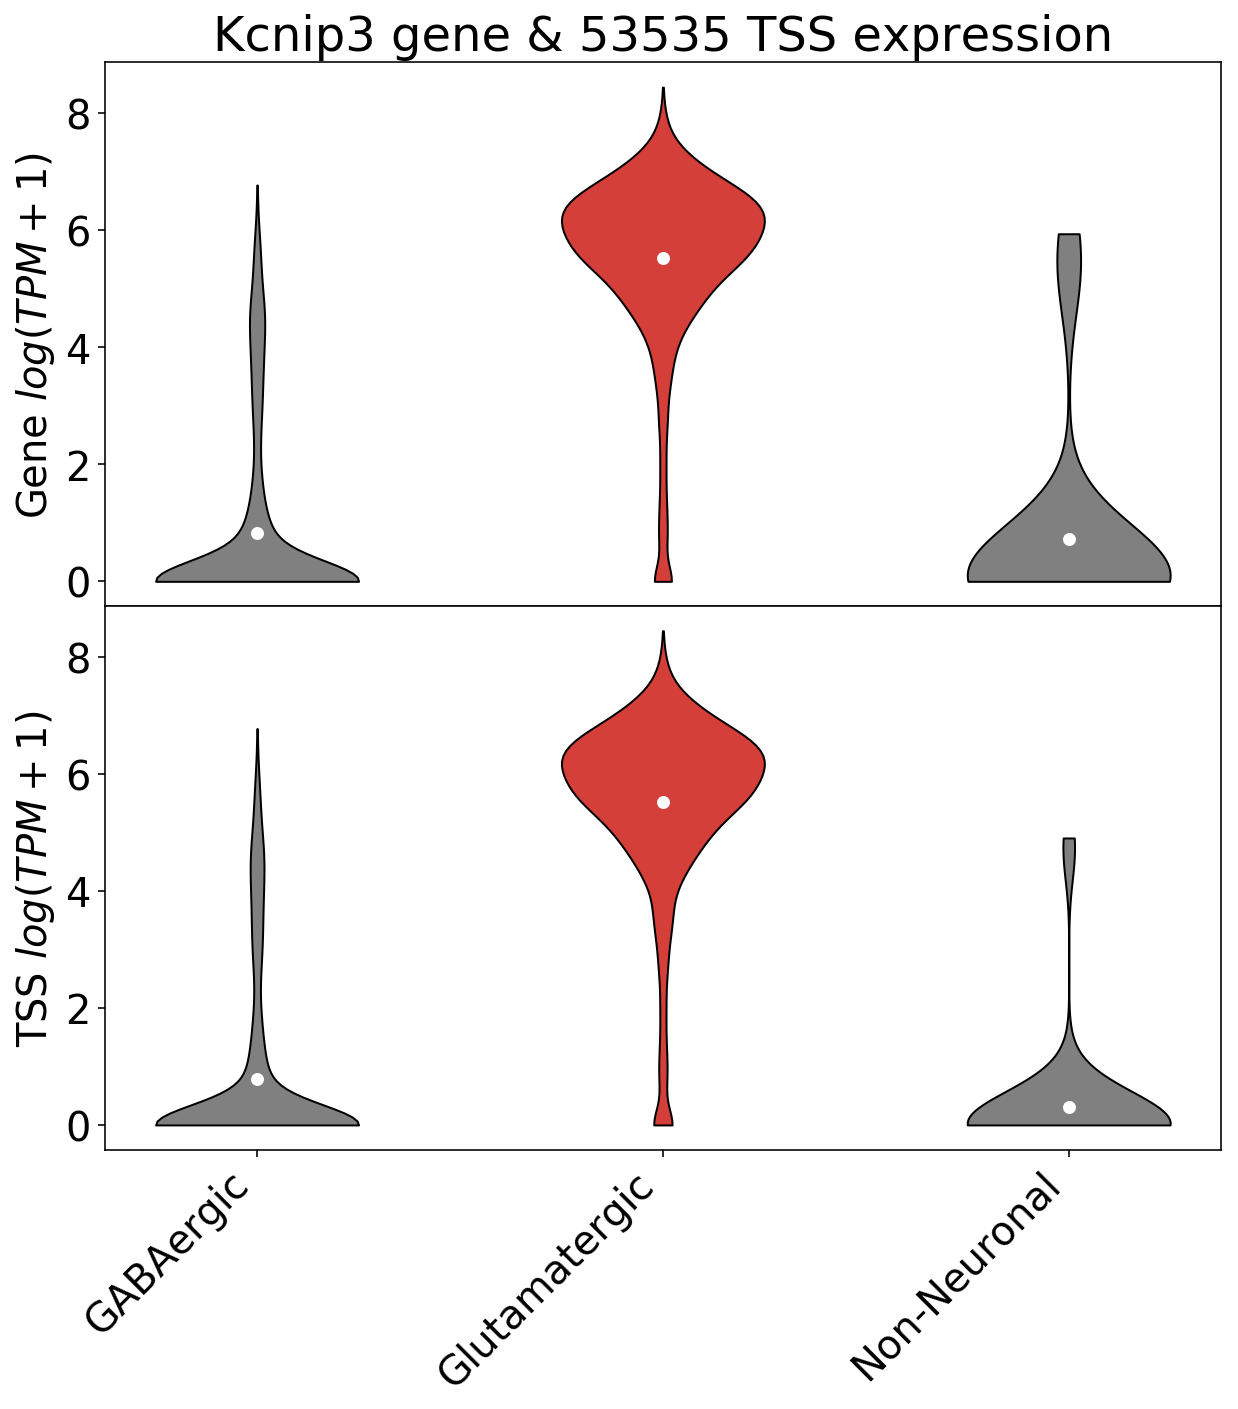

In [819]:
fig, ax = plt.subplots(figsize=(10,10), nrows=2)
fig.subplots_adjust(hspace=0, wspace=0)

unique = np.unique(stss.obs.class_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))

midx = np.where(unique==specific_cluster)[0][0]
labels = unique
lidx = np.arange(1, len(labels)+1)

tss_0 = specific_tss

###
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.class_label==c][:,gene.var.gene_name==specific_gene].layers["log1p"]).reshape(-1).tolist())
    
parts = ax[0].violinplot(x, showmedians=False, showextrema=False, positions=lidx)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')
        


medians = [np.mean(i) for i in x]
ax[0].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)
ax[0].set_ylabel("Gene $log(TPM + 1)$")


### TSS specific
x = []
for c in unique:
    x.append(np.asarray(stss[stss.obs.class_label==c][:,stss.var.tss_class==tss_0].layers["log1p"]).reshape(-1).tolist())
    
parts = ax[1].violinplot(x, showmedians=False, showextrema=False, positions=lidx)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')
        


medians = [np.mean(i) for i in x]
ax[1].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)


ax[1].set_xticks(lidx)
ax[1].set_xticklabels(labels, rotation=45, ha="right")
ax[1].set_ylabel("TSS $log(TPM + 1)$")
ymin, ymax = ax[0].get_ylim()
ax[1].set_ylim((ymin, ymax))
ax[0].set_title("{} gene & {} TSS expression".format(specific_gene, specific_tss))
#plt.savefig("./level_3_fig/tss_violin_{}.png".format(specific_gene), bbox_inches='tight',dpi=300)
plt.show()

# TSS against each other

In [ ]:
28886, 28887, 28888, 28889, 28890, 28891, 28892

In [820]:
tss_0 = specific_tss
tss_1 = 53534

In [821]:
c0 = np.asarray(stss[:,stss.var.tss_class == tss_0].X).reshape(-1)
c1 = np.asarray(stss[:,stss.var.tss_class == tss_1].X).reshape(-1)

27-Feb-20 11:53:58 - update_title_pos
27-Feb-20 11:53:58 - update_title_pos
27-Feb-20 11:53:58 - update_title_pos
27-Feb-20 11:53:58 - update_title_pos
27-Feb-20 11:53:58 - update_title_pos
27-Feb-20 11:53:58 - update_title_pos
27-Feb-20 11:53:58 - update_title_pos
27-Feb-20 11:53:58 - update_title_pos


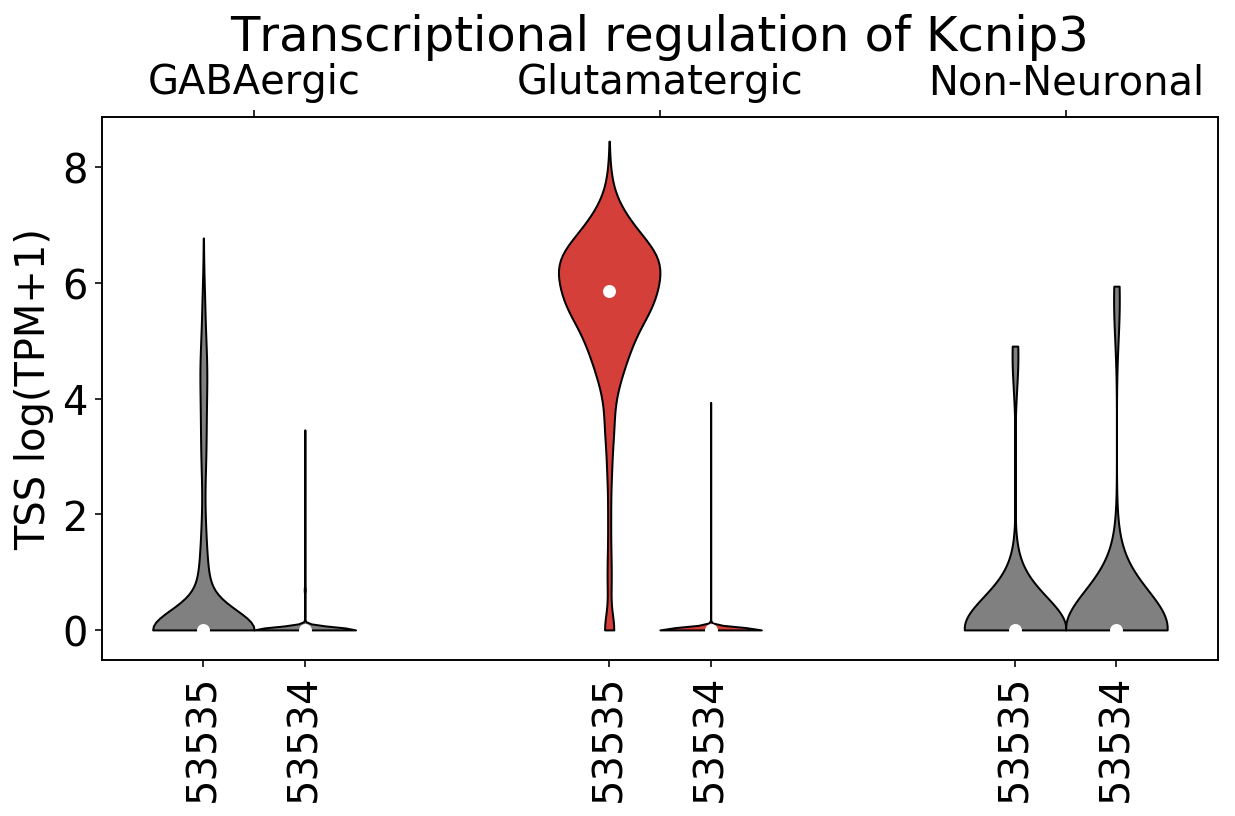

In [822]:
fig, ax = plt.subplots(figsize=(10,5))

unique = np.unique(gene.obs.class_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))

midx = np.where(unique==specific_cluster)[0][0]
labels = unique
lidx = np.arange(0.25, len(labels)*2+0.25, 2)
ridx = np.arange(0.75, len(labels)*2 + 0.75, 2)
cidx = np.arange(0.50, len(labels)*2+0.5, 2)


lridx = np.union1d(lidx, ridx)
sub_labels = [tss_0, tss_1]*len(lidx)



x = []
y = []
for c in unique:
    x.append(np.asarray(stss[stss.obs.class_label==c][:,stss.var.tss_class==tss_0].layers["log1p"]).reshape(-1).tolist())
    y.append(np.asarray(stss[stss.obs.class_label==c][:,stss.var.tss_class==tss_1].layers["log1p"]).reshape(-1).tolist())
    
left = ax.violinplot(x, showmedians=False, showextrema=False, positions=lidx)
right = ax.violinplot(y, showmedians=False, showextrema=False, positions=ridx)
for pcidx, pc in enumerate(left['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')
        
for pcidx, pc in enumerate(right['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')

medians = [np.median(i) for i in x]
ax.scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

medians = [np.median(i) for i in y]
ax.scatter(ridx, medians, marker='o', color='white', s=30, zorder=3)

ax2 = ax.twiny()
ax.set_xticks(lridx)
ax.set_xticklabels(sub_labels, rotation=90, ha="center")

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(cidx)
ax2.set_xticklabels(labels, rotation=0, ha="center")

ax.set_ylabel("TSS log(TPM+1)")
ax.set_title("Transcriptional regulation of {}".format(specific_gene))

#plt.savefig("./level_3_fig/tss_violin_transcriptional_{}.png".format(specific_gene), bbox_inches='tight', dpi=300)

plt.show()

# Ptk2b isoforms against each other

In [823]:
iso0, iso1 = ft2g[ft2g["tss_class"] == specific_tss]["tss_same"].values[0]

In [824]:
iso0 = iso0.split(".")[0]
iso1 = iso1.split(".")[0]

27-Feb-20 11:54:04 - update_title_pos
27-Feb-20 11:54:04 - update_title_pos
27-Feb-20 11:54:05 - update_title_pos
27-Feb-20 11:54:05 - update_title_pos
27-Feb-20 11:54:05 - update_title_pos
27-Feb-20 11:54:05 - update_title_pos
27-Feb-20 11:54:05 - update_title_pos
27-Feb-20 11:54:05 - update_title_pos


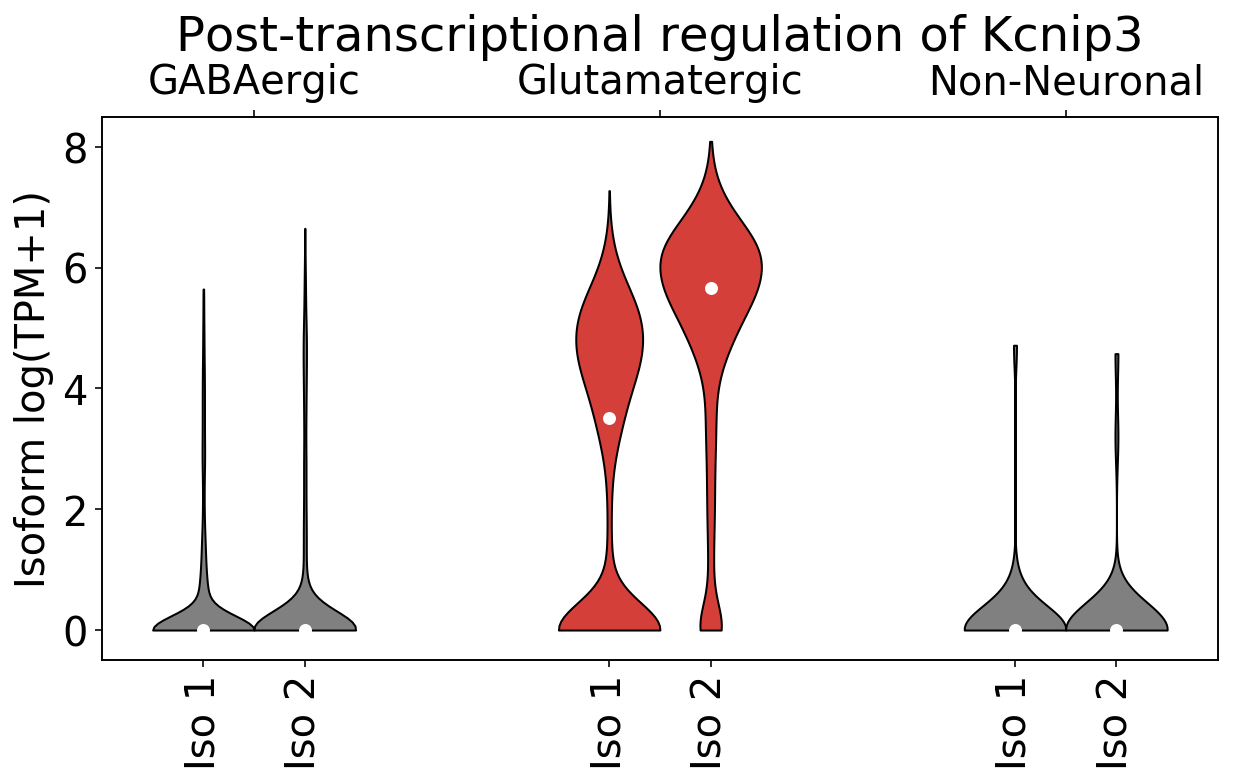

In [825]:
fig, ax = plt.subplots(figsize=(10,5))

unique = np.unique(gene.obs.class_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))

midx = np.where(unique==specific_cluster)[0][0]
labels = unique


lidx = np.arange(0.25, len(labels)*2+0.25, 2)
ridx = np.arange(0.75, len(labels)*2 + 0.75, 2)
cidx = np.arange(0.50, len(labels)*2+0.5, 2)

lridx = np.union1d(lidx, ridx)
sub_labels = ["Iso 1", "Iso 2"]*len(lidx)


x = []
y = []
for c in unique:
    x.append(np.asarray(isoform[isoform.obs.class_label==c][:,isoform.var.transcript_id==iso0].layers["log1p"].todense()).reshape(-1).tolist())
    y.append(np.asarray(isoform[isoform.obs.class_label==c][:,isoform.var.transcript_id==iso1].layers["log1p"].todense()).reshape(-1).tolist())
    
left = ax.violinplot(x, showmedians=False, showextrema=False, positions=lidx)
right = ax.violinplot(y, showmedians=False, showextrema=False, positions=ridx)
for pcidx, pc in enumerate(left['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')
        
for pcidx, pc in enumerate(right['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')

medians = [np.median(i) for i in x]
ax.scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

medians = [np.median(i) for i in y]
ax.scatter(ridx, medians, marker='o', color='white', s=30, zorder=3)

ax2 = ax.twiny()
ax.set_xticks(lridx)
ax.set_xticklabels(sub_labels, rotation=90, ha="center")

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(cidx)
ax2.set_xticklabels(labels, rotation=0, ha="center")

ax.set_ylabel("Isoform log(TPM+1)")
ax.set_title("Post-transcriptional regulation of {}".format(specific_gene))
#plt.savefig("./level_3_fig/tss_violin_post-transcriptional_{}.png".format(specific_gene), bbox_inches='tight', dpi=300)

plt.show()

# Ptprd Gene

In [466]:
specific_gene = "Ptprd"
specific_tss = 60306
tss_class = g2tss.loc[specific_gene]["tss_class"]
print(tss_class)

[60294, 60295, 60296, 60297, 60298, 60299, 60300, 60301, 60302, 60303, 60304, 60305, 60306, 60307, 60308, 60309, 60310, 60311]


27-Feb-20 01:36:00 - update_title_pos
27-Feb-20 01:36:00 - update_title_pos
27-Feb-20 01:36:01 - update_title_pos
27-Feb-20 01:36:01 - update_title_pos
27-Feb-20 01:36:01 - update_title_pos
27-Feb-20 01:36:01 - update_title_pos
27-Feb-20 01:36:02 - update_title_pos
27-Feb-20 01:36:02 - update_title_pos
27-Feb-20 01:36:02 - update_title_pos
27-Feb-20 01:36:03 - update_title_pos
27-Feb-20 01:36:03 - update_title_pos
27-Feb-20 01:36:03 - update_title_pos
27-Feb-20 01:36:03 - update_title_pos
27-Feb-20 01:36:03 - update_title_pos
27-Feb-20 01:36:03 - update_title_pos
27-Feb-20 01:36:03 - update_title_pos
27-Feb-20 01:36:03 - update_title_pos
27-Feb-20 01:36:03 - update_title_pos


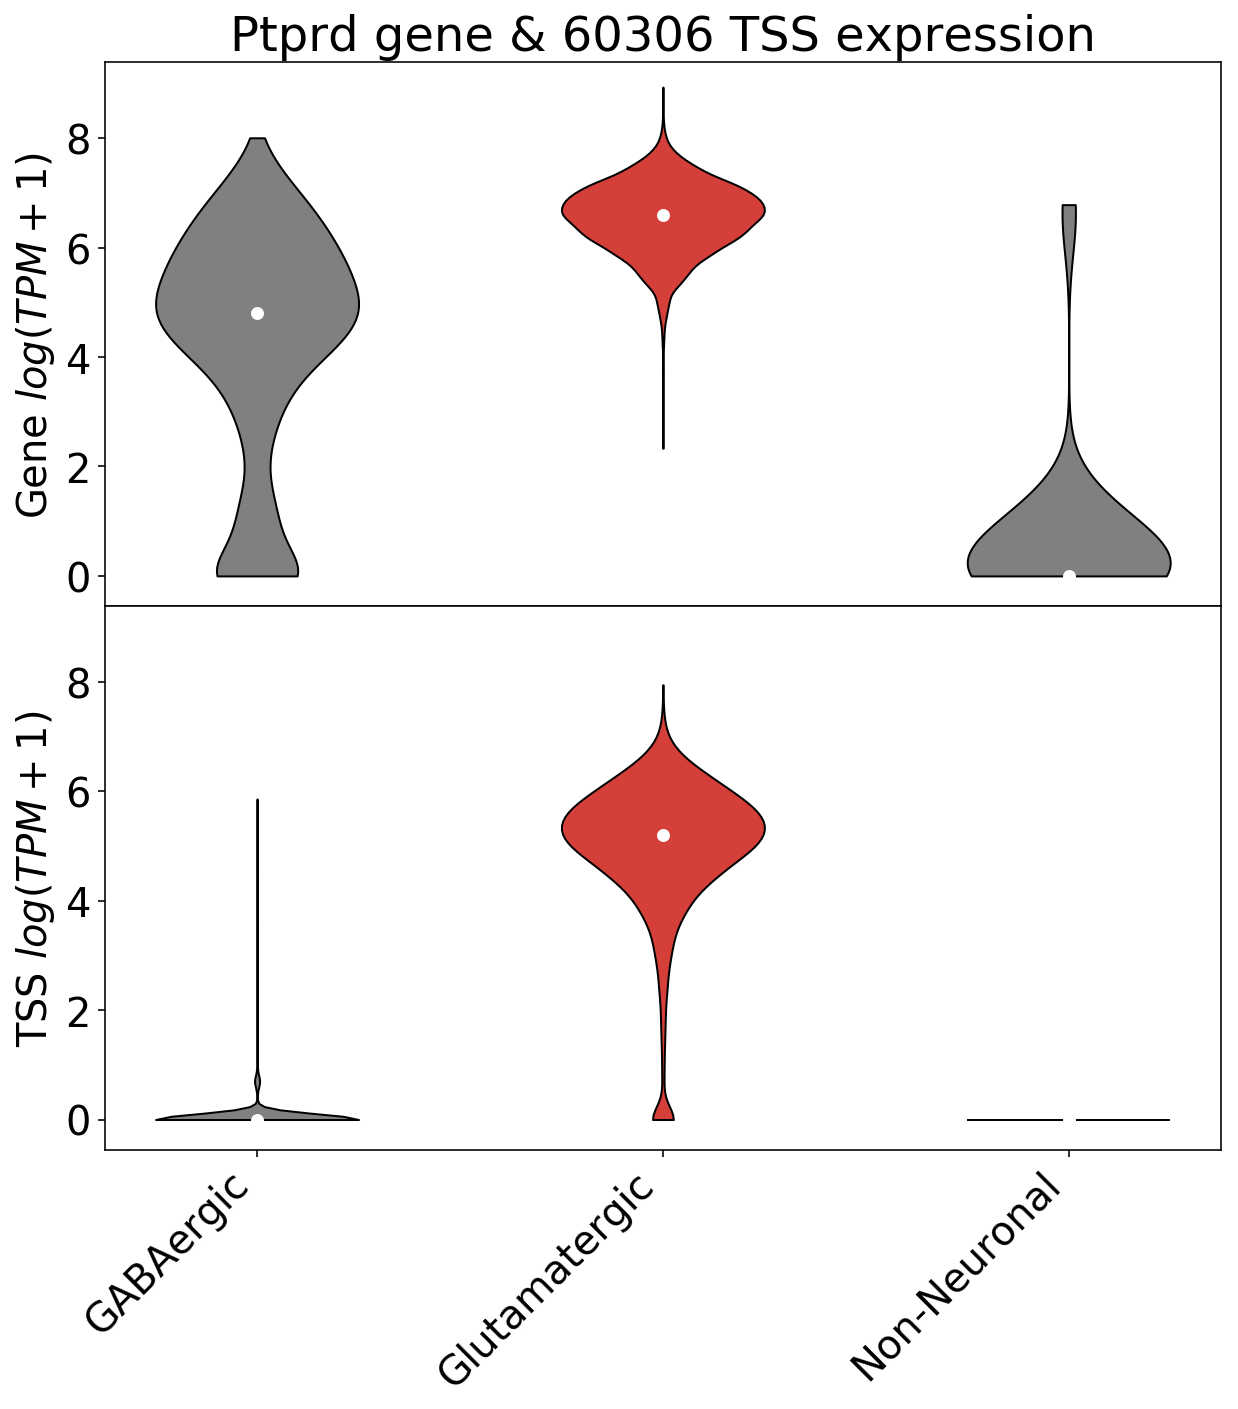

In [484]:
fig, ax = plt.subplots(figsize=(10,10), nrows=2)
fig.subplots_adjust(hspace=0, wspace=0)

unique = np.unique(gene.obs.class_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))

midx = np.where(unique==specific_cluster)[0][0]
labels = unique
lidx = np.arange(1, len(labels)+1)

tss_0 = specific_tss

###
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.class_label==c][:,gene.var.gene_name==specific_gene].layers["log1p"]).reshape(-1).tolist())
    
parts = ax[0].violinplot(x, showmedians=False, showextrema=False, positions=lidx)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')
        


medians = [np.median(i) for i in x]
ax[0].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)
ax[0].set_ylabel("Gene $log(TPM + 1)$")


### TSS specific
x = []
for c in unique:
    x.append(np.asarray(stss[stss.obs.class_label==c][:,stss.var.tss_class==tss_0].X).reshape(-1).tolist())
    
parts = ax[1].violinplot(x, showmedians=False, showextrema=False, positions=lidx)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')
        


medians = [np.median(i) for i in x]
ax[1].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)


ax[1].set_xticks(lidx)
ax[1].set_xticklabels(labels, rotation=45, ha="right")
ax[1].set_ylabel("TSS $log(TPM + 1)$")
ymin, ymax = ax[0].get_ylim()
ax[1].set_ylim((ymin, ymax))
ax[0].set_title("{} gene & {} TSS expression".format(specific_gene, specific_tss))
plt.savefig("./level_3_fig/tss_violin_{}.png".format(specific_gene), bbox_inches='tight',dpi=300)
plt.show()

27-Feb-20 01:36:04 - update_title_pos
27-Feb-20 01:36:04 - update_title_pos
27-Feb-20 01:36:04 - update_title_pos
27-Feb-20 01:36:04 - update_title_pos
27-Feb-20 01:36:05 - update_title_pos
27-Feb-20 01:36:05 - update_title_pos
27-Feb-20 01:36:05 - update_title_pos
27-Feb-20 01:36:05 - update_title_pos
27-Feb-20 01:36:05 - update_title_pos


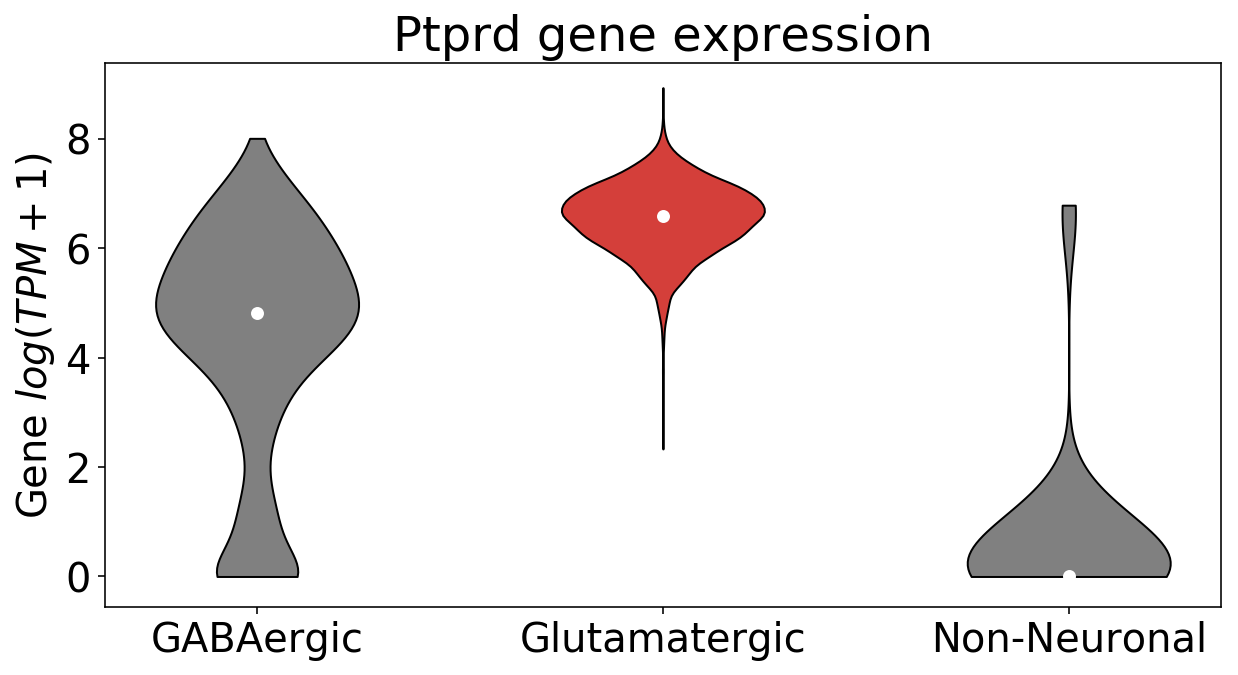

In [485]:
fig, ax = plt.subplots(figsize=(10,5))
fig.subplots_adjust(hspace=0, wspace=0)

unique = np.unique(gene.obs.class_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))

midx = np.where(unique==specific_cluster)[0][0]
labels = unique
lidx = np.arange(1, len(labels)+1)

tss_0 = specific_tss

###
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.class_label==c][:,gene.var.gene_name==specific_gene].layers["log1p"]).reshape(-1).tolist())
    
parts = ax.violinplot(x, showmedians=False, showextrema=False, positions=lidx)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')
        


medians = [np.median(i) for i in x]
ax.scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)
ax.set_ylabel("Gene $log(TPM + 1)$")
        
ax.set_xticks(lidx)
ax.set_xticklabels(labels, rotation=0, ha="center")
ax.set_title("{} gene expression".format(specific_gene))
plt.savefig("./level_3_fig/tss_violin_gene_{}.png".format(specific_gene), bbox_inches='tight',dpi=300)
plt.show()

In [486]:
tss_0 = specific_tss
tss_1 = 60298

In [487]:
c0 = np.asarray(stss[:,stss.var.tss_class == tss_0].X).reshape(-1)
c1 = np.asarray(stss[:,stss.var.tss_class == tss_1].X).reshape(-1)
#c2 = np.asarray(stss[:,stss.var.tss_class == tss_class[2]].X).reshape(-1)

27-Feb-20 01:36:15 - update_title_pos
27-Feb-20 01:36:15 - update_title_pos
27-Feb-20 01:36:16 - update_title_pos
27-Feb-20 01:36:18 - update_title_pos
27-Feb-20 01:36:18 - update_title_pos
27-Feb-20 01:36:18 - update_title_pos
27-Feb-20 01:36:18 - update_title_pos
27-Feb-20 01:36:18 - update_title_pos
27-Feb-20 01:36:18 - update_title_pos
27-Feb-20 01:36:18 - update_title_pos
27-Feb-20 01:36:18 - update_title_pos
27-Feb-20 01:36:19 - update_title_pos
27-Feb-20 01:36:21 - update_title_pos
27-Feb-20 01:36:21 - update_title_pos
27-Feb-20 01:36:21 - update_title_pos
27-Feb-20 01:36:21 - update_title_pos
27-Feb-20 01:36:21 - update_title_pos
27-Feb-20 01:36:21 - update_title_pos
27-Feb-20 01:36:22 - update_title_pos
27-Feb-20 01:36:22 - update_title_pos
27-Feb-20 01:36:22 - update_title_pos
27-Feb-20 01:36:22 - update_title_pos
27-Feb-20 01:36:22 - update_title_pos
27-Feb-20 01:36:22 - update_title_pos
27-Feb-20 01:36:22 - update_title_pos
27-Feb-20 01:36:22 - update_title_pos
27-Feb-20 01

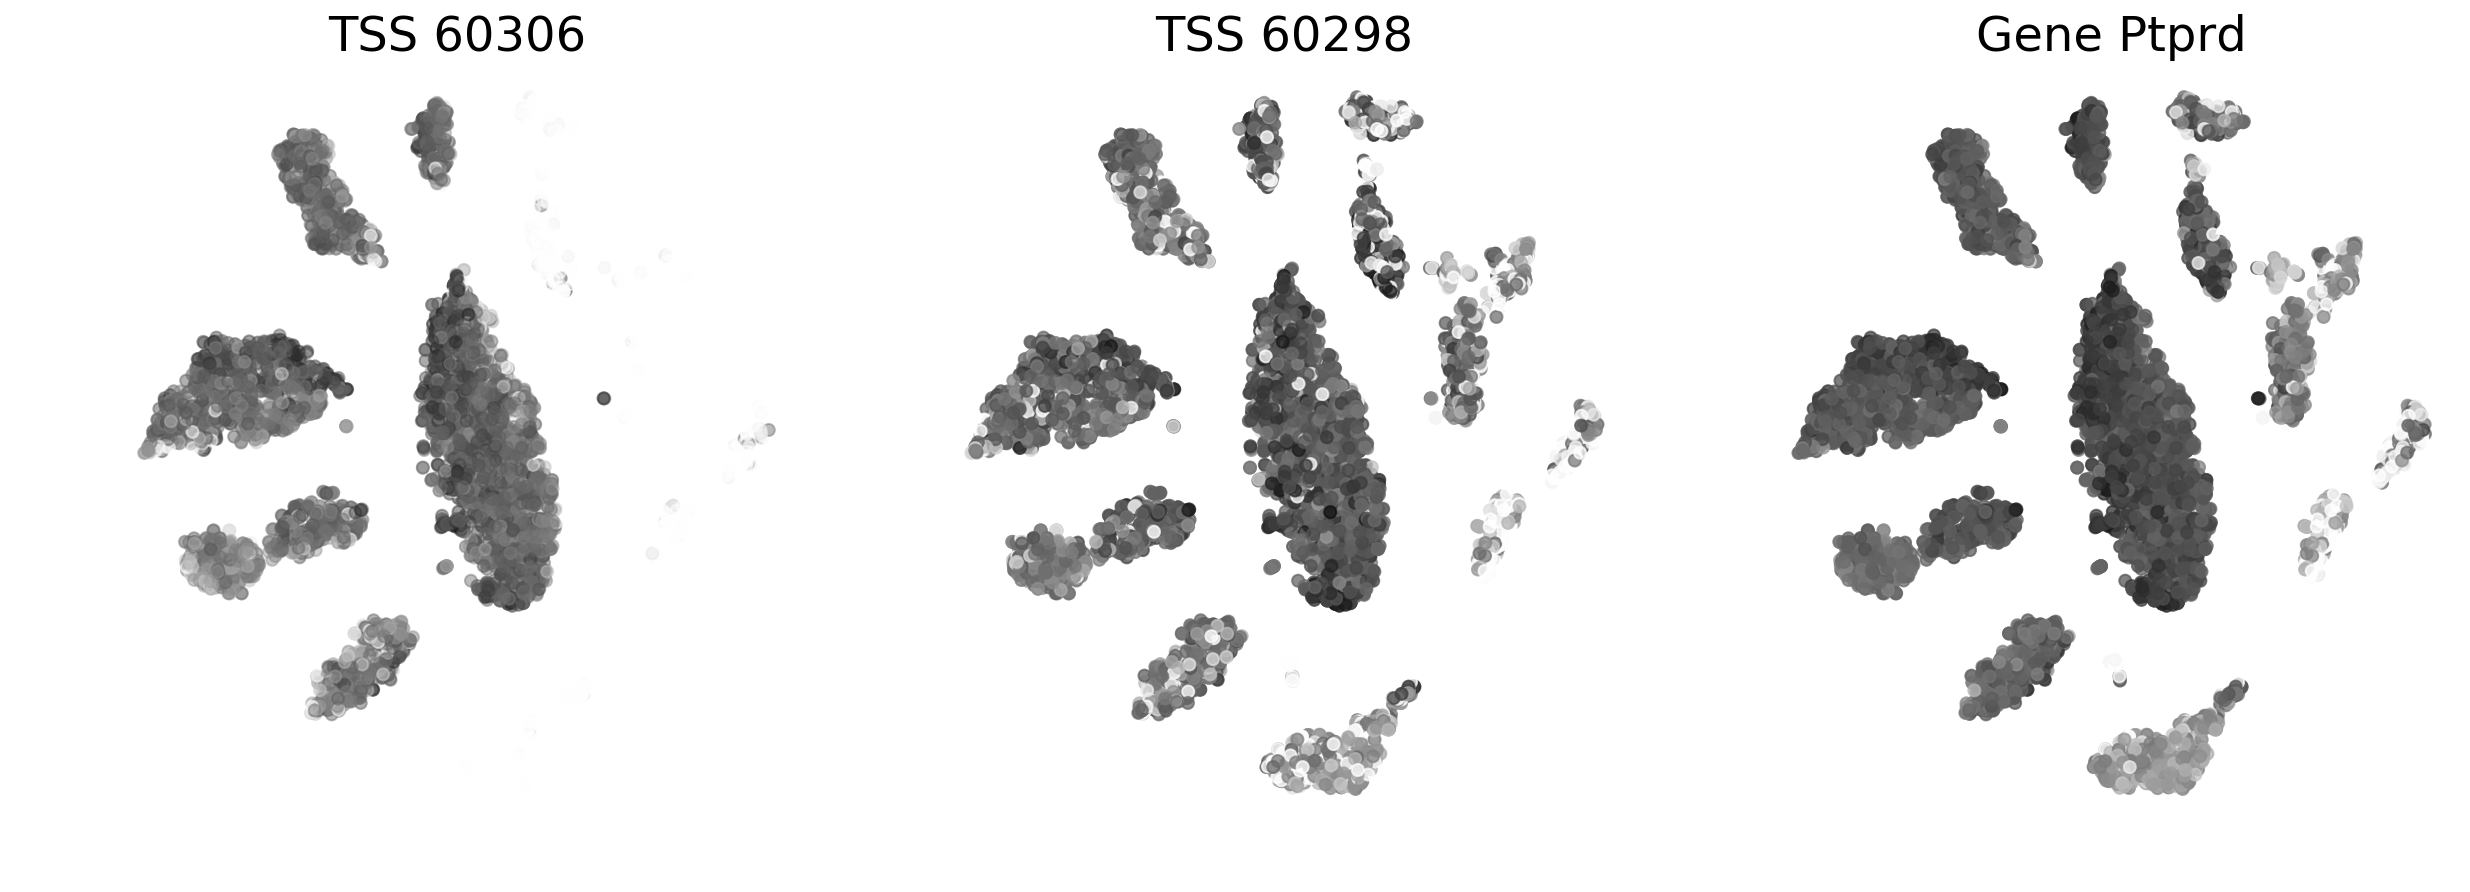

In [488]:
#specific_gene = "Ank3"#Nrgn Rorb

fig, ax = plt.subplots(figsize=(21,7), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
#c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
c = c0
cmap="Greys"
alpha = 0.5

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()
ax[0].set_title("TSS {}".format(tss_0))
####

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = c1
cmap="Greys"
alpha = 0.75

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off() 
ax[1].set_title("TSS {}".format(tss_1))

# ######
x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"]).reshape(-1)
cmap="Greys"
alpha = 0.75

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off() 
ax[2].set_title("Gene {}".format(specific_gene))

plt.savefig("./level_3_fig/tss_nca_{}.png".format(specific_gene), bbox_inches='tight',dpi=300)

plt.show()

# Plot
each cluster is a violin plot, number of TSS is number of violins, 
plot the distribution of that tss within the cluster

27-Feb-20 01:36:30 - update_title_pos
27-Feb-20 01:36:30 - update_title_pos
27-Feb-20 01:36:30 - update_title_pos
27-Feb-20 01:36:30 - update_title_pos
27-Feb-20 01:36:30 - update_title_pos
27-Feb-20 01:36:30 - update_title_pos
27-Feb-20 01:36:30 - update_title_pos
27-Feb-20 01:36:30 - update_title_pos


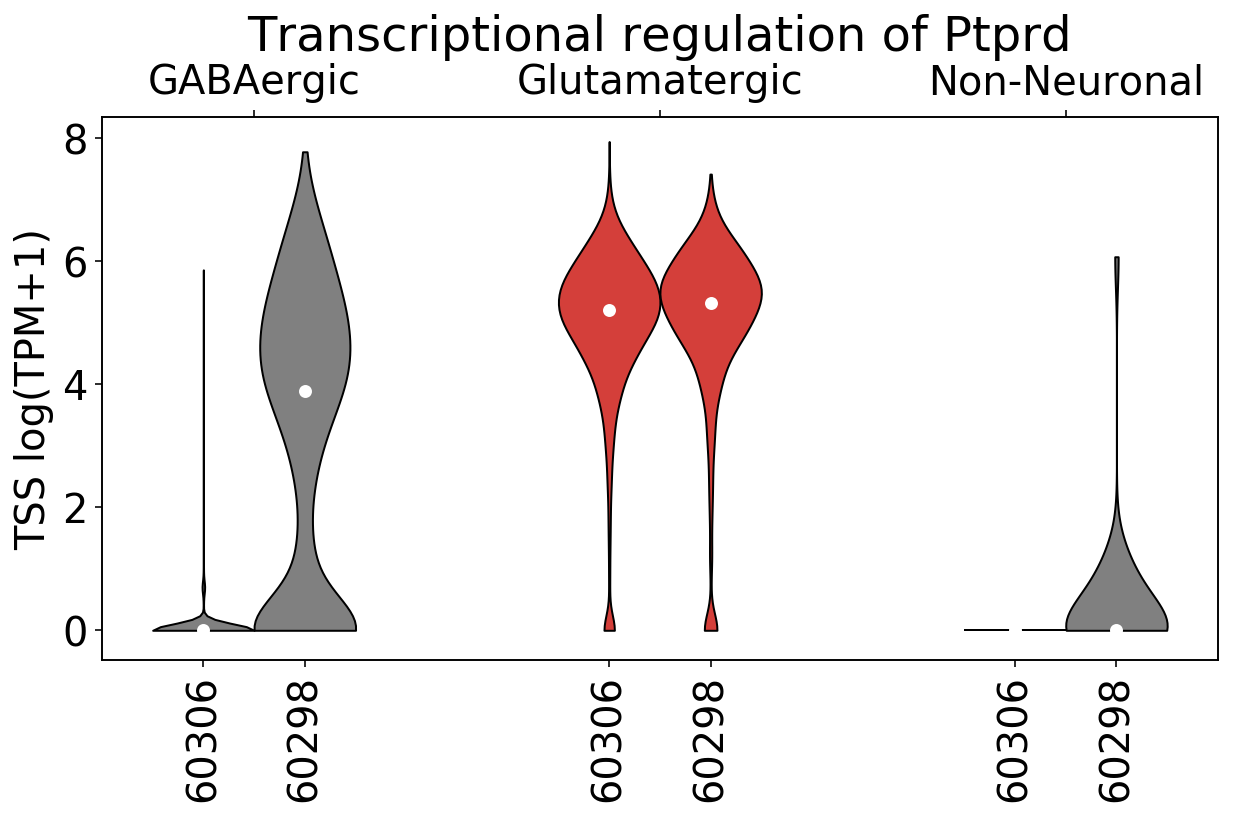

In [489]:
fig, ax = plt.subplots(figsize=(10,5))

unique = np.unique(gene.obs.class_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))

midx = np.where(unique==specific_cluster)[0][0]
labels = unique
lidx = np.arange(0.25, len(labels)*2+0.25, 2)
ridx = np.arange(0.75, len(labels)*2 + 0.75, 2)
cidx = np.arange(0.50, len(labels)*2+0.5, 2)


lridx = np.union1d(lidx, ridx)
sub_labels = [tss_0, tss_1]*len(lidx)



x = []
y = []
for c in unique:
    x.append(np.asarray(stss[stss.obs.class_label==c][:,stss.var.tss_class==tss_0].X).reshape(-1).tolist())
    y.append(np.asarray(stss[stss.obs.class_label==c][:,stss.var.tss_class==tss_1].X).reshape(-1).tolist())
    
left = ax.violinplot(x, showmedians=False, showextrema=False, positions=lidx)
right = ax.violinplot(y, showmedians=False, showextrema=False, positions=ridx)
for pcidx, pc in enumerate(left['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')
        
for pcidx, pc in enumerate(right['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')

medians = [np.median(i) for i in x]
ax.scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

medians = [np.median(i) for i in y]
ax.scatter(ridx, medians, marker='o', color='white', s=30, zorder=3)

ax2 = ax.twiny()
ax.set_xticks(lridx)
ax.set_xticklabels(sub_labels, rotation=90, ha="center")

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(cidx)
ax2.set_xticklabels(labels, rotation=0, ha="center")

ax.set_ylabel("TSS log(TPM+1)")
ax.set_title("Transcriptional regulation of {}".format(specific_gene))

#plt.savefig("./level_3_fig/tss_violin_transcriptional_{}.png".format(specific_gene), bbox_inches='tight', dpi=300)

plt.show()

In [490]:
iso0, iso1 = tmp[tmp.tss_class == specific_tss].index.values

In [491]:
iso1

'ENSMUST00000173592'

27-Feb-20 01:36:53 - update_title_pos
27-Feb-20 01:36:53 - update_title_pos
27-Feb-20 01:36:54 - update_title_pos
27-Feb-20 01:36:54 - update_title_pos
27-Feb-20 01:36:54 - update_title_pos
27-Feb-20 01:36:54 - update_title_pos
27-Feb-20 01:36:54 - update_title_pos
27-Feb-20 01:36:54 - update_title_pos
27-Feb-20 01:36:54 - update_title_pos
27-Feb-20 01:36:54 - update_title_pos
27-Feb-20 01:36:54 - update_title_pos
27-Feb-20 01:36:54 - update_title_pos
27-Feb-20 01:36:55 - update_title_pos
27-Feb-20 01:36:55 - update_title_pos
27-Feb-20 01:36:55 - update_title_pos
27-Feb-20 01:36:55 - update_title_pos
27-Feb-20 01:36:55 - update_title_pos
27-Feb-20 01:36:55 - update_title_pos


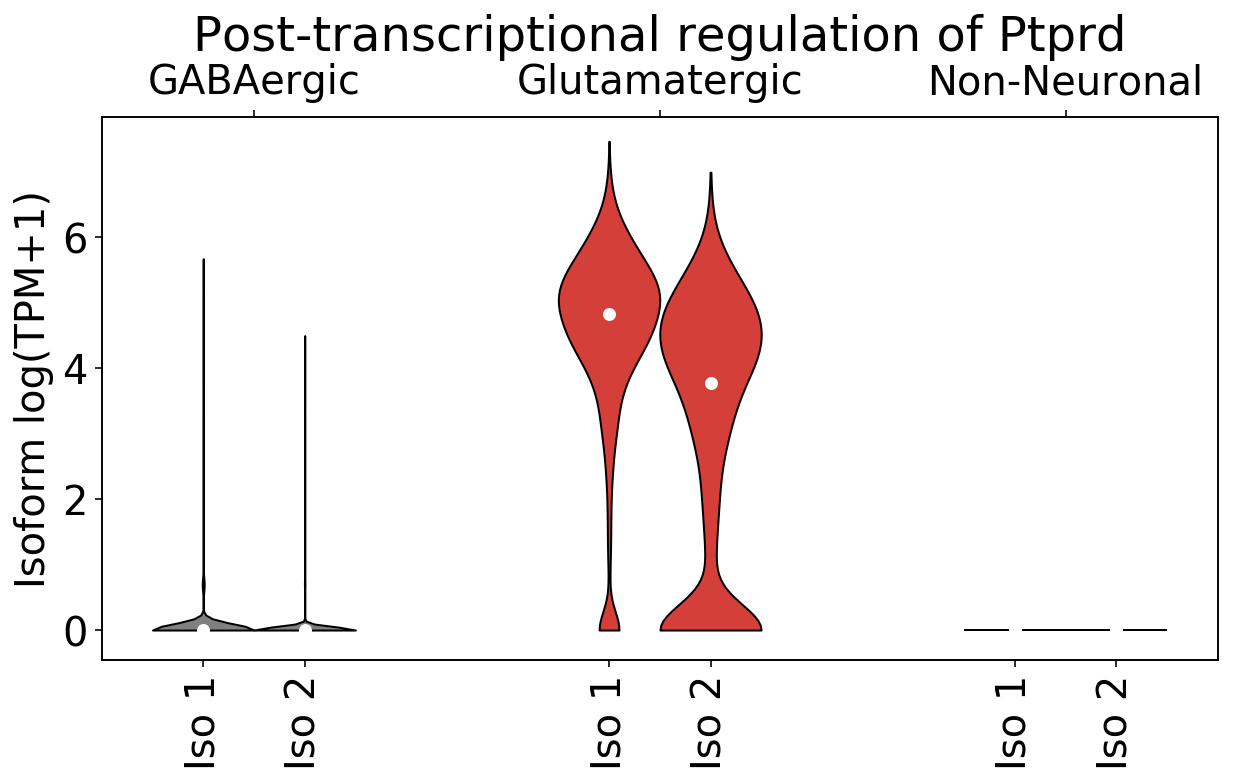

In [493]:
iso0, iso1 = tmp[tmp.tss_class == specific_tss].index.values

fig, ax = plt.subplots(figsize=(10,5))

unique = np.unique(gene.obs.class_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))

midx = np.where(unique==specific_cluster)[0][0]
labels = unique


lidx = np.arange(0.25, len(labels)*2+0.25, 2)
ridx = np.arange(0.75, len(labels)*2 + 0.75, 2)
cidx = np.arange(0.50, len(labels)*2+0.5, 2)

lridx = np.union1d(lidx, ridx)
sub_labels = ["Iso 1", "Iso 2"]*len(lidx)


x = []
y = []
for c in unique:
    x.append(np.asarray(isoform[isoform.obs.class_label==c][:,isoform.var.transcript_id==iso0].layers["log1p"].todense()).reshape(-1).tolist())
    y.append(np.asarray(isoform[isoform.obs.class_label==c][:,isoform.var.transcript_id==iso1].layers["log1p"].todense()).reshape(-1).tolist())
    
left = ax.violinplot(x, showmedians=False, showextrema=False, positions=lidx)
right = ax.violinplot(y, showmedians=False, showextrema=False, positions=ridx)
for pcidx, pc in enumerate(left['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')
        
for pcidx, pc in enumerate(right['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')

medians = [np.median(i) for i in x]
ax.scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

medians = [np.median(i) for i in y]
ax.scatter(ridx, medians, marker='o', color='white', s=30, zorder=3)

ax2 = ax.twiny()
ax.set_xticks(lridx)
ax.set_xticklabels(sub_labels, rotation=90, ha="center")

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(cidx)
ax2.set_xticklabels(labels, rotation=0, ha="center")

ax.set_ylabel("Isoform log(TPM+1)")
ax.set_title("Post-transcriptional regulation of {}".format(specific_gene))
plt.savefig("./level_3_fig/tss_violin_post-transcriptional_{}.png".format(specific_gene), bbox_inches='tight', dpi=300)

plt.show()

# Subclass

In [108]:
%%time

mat         = stss.X
components  = stss.obs.cell_id.values
features    = stss.var.tss_class.values
assignments = stss.obs.subclass_label.values
unique = np.unique(assignments)
# %lprun -f dexpress dexpress(mat, components, features, assignments)
pval, pval_corr, stat = dexpress(mat, components, features, assignments, nan_cutoff=0.90)

26-Feb-20 14:27:46 - 1 of 18 assignments: Astro
26-Feb-20 14:27:46 - 2 of 18 assignments: Endo
26-Feb-20 14:27:47 - 3 of 18 assignments: L2/3 IT
26-Feb-20 14:27:48 - 4 of 18 assignments: L5 ET
26-Feb-20 14:27:49 - 5 of 18 assignments: L5 IT
26-Feb-20 14:27:49 - 6 of 18 assignments: L5/6 NP
26-Feb-20 14:27:50 - 7 of 18 assignments: L6 CT
26-Feb-20 14:27:51 - 8 of 18 assignments: L6 IT
26-Feb-20 14:27:52 - 9 of 18 assignments: L6 IT Car3
26-Feb-20 14:27:52 - 10 of 18 assignments: L6b
26-Feb-20 14:27:53 - 11 of 18 assignments: Lamp5
26-Feb-20 14:27:54 - 12 of 18 assignments: Low Quality
26-Feb-20 14:27:55 - 13 of 18 assignments: Pvalb
26-Feb-20 14:27:55 - 14 of 18 assignments: SMC
26-Feb-20 14:27:56 - 15 of 18 assignments: Sncg
26-Feb-20 14:27:57 - 16 of 18 assignments: Sst
26-Feb-20 14:27:58 - 17 of 18 assignments: VLMC
26-Feb-20 14:27:58 - 18 of 18 assignments: Vip


CPU times: user 8.52 s, sys: 5.05 s, total: 13.6 s
Wall time: 13.6 s


In [109]:
(~np.isnan(pval_corr)).sum()

5699

# Notes
- Grin1 Check Glut vs GABA
- 

In [77]:
stss.obs.subclass_label.value_counts()

L5 IT          1560
L6 CT           904
L6b             568
Vip             555
Pvalb           496
L2/3 IT         482
L6 IT           395
Sst             391
Lamp5           348
L5/6 NP         207
Sncg             71
SMC              17
Low Quality      12
L5 ET            12
Endo              7
Astro             7
VLMC              6
L6 IT Car3        5
Name: subclass_label, dtype: int64

In [118]:
specific_cluster = "L5 IT"

cidx = np.where(unique==specific_cluster)[0][0]
mask = pval_corr[cidx]<0.01
psort = np.argsort(pval_corr[cidx][mask])

top_tss_class = features[mask][psort]

In [119]:
g2tss = pd.DataFrame(stss.var.groupby("gene_name")["tss_class"].apply(list))
g2tss["n_tss"] = g2tss["tss_class"].apply(lambda x: len(x))

In [120]:
two = g2tss[g2tss["n_tss"]==2]["tss_class"].explode()

In [121]:
two[two.isin(top_tss_class)]

gene_name
9530068E07Rik     15390
Akap5             19083
Arpc5               253
Atp6v1f           72661
Ccdc32            51086
Ccdc59             7071
Ccnt2              1943
Cdh11             88952
Chrm1             44753
Cmah              22157
Cnksr2            99240
Commd2            57060
Commd2            57061
D1Ertd622e         4055
Dexi              36378
Glyr1             34908
Glyr1             34909
Gsk3a             84573
Hspd1               806
Hspd1               807
Il1rapl1         100869
Ildr2              3647
Lockd             77712
Lzts3             50535
M6pr              72782
Mmd2              69444
Mrps14             4764
Mt3               89147
Ndufa9            72379
Nsg2              13131
Nsrp1             15498
Olfr539           84743
Pdcd4             44311
Pias2             42430
Plppr4            57873
Polr2j            69500
Prodh2            82252
Rab5c             12907
Rasgef1a          74190
Rgs4               3459
Rnf14             43112
Sdccag

In [122]:
specific_gene = "Znrf3"
tss_class = g2tss.loc[specific_gene]["tss_class"]
print(tss_class)

[16043, 16044]


In [123]:
specific_tss = 16044

In [124]:
tmp[tmp.tss_class == specific_tss]

,chromosome,gene_id,new_start,tss_same,tss_len,n_tss_same,n_iso,max_tss_size,num_tss_1_iso,tss_class
ENSMUST00000109867,11,ENSMUSG00000041961,5444847,ENSMUST00000109867,2,2,3,2,1,16044
ENSMUST00000143746,11,ENSMUSG00000041961,5444847,ENSMUST00000143746,2,2,3,2,1,16044


Get list of TSS classes, for each look up the isoforms and slice mtx by those isoforms and sum to make a vector
do this for all TSS in list

In [96]:
unique

array(['Astro', 'Endo', 'L2/3 IT', 'L5 ET', 'L5 IT', 'L5/6 NP', 'L6 CT',
       'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Pvalb', 'SMC', 'Sncg',
       'Sst', 'VLMC', 'Vip'], dtype=object)

26-Feb-20 14:30:36 - update_title_pos
26-Feb-20 14:30:36 - update_title_pos
26-Feb-20 14:30:36 - update_title_pos
26-Feb-20 14:30:36 - update_title_pos


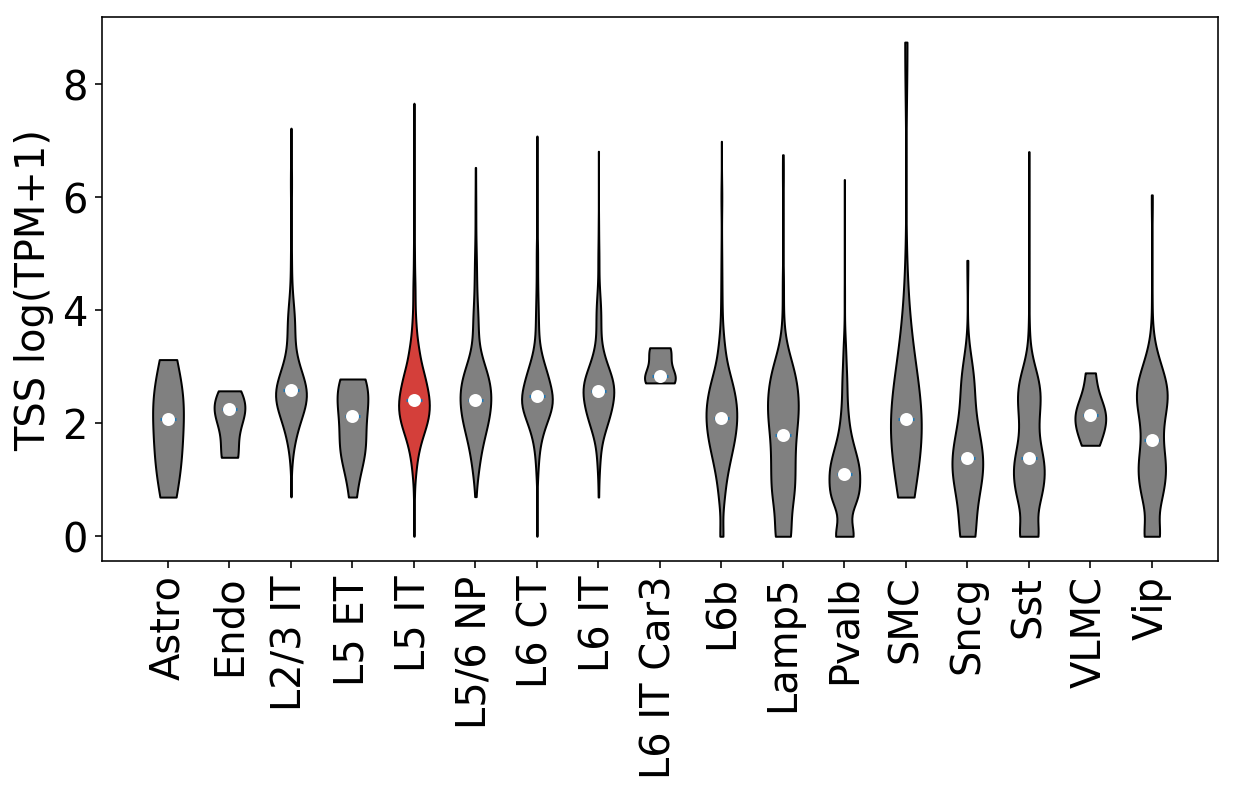

In [125]:
fig, ax = plt.subplots(figsize=(10,5))

unique = np.unique(gene.obs.subclass_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))

midx = np.where(unique==specific_cluster)[0][0]
labels = unique
lidx = np.arange(1, len(labels)+1)

tss_0 = specific_tss

x = []
for c in unique:
    x.append(np.asarray(stss[stss.obs.subclass_label==c][:,stss.var.tss_class==tss_0].X).reshape(-1).tolist())
    
parts = ax.violinplot(x, showmedians=True, showextrema=False, positions=lidx)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')
        


medians = [np.median(i) for i in x]
ax.scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)


ax.set_xticks(lidx)
ax.set_xticklabels(labels, rotation=90, ha="center")
ax.set_ylabel("TSS log(TPM+1)")
plt.show()

In [126]:
c0 = np.asarray(stss[:,stss.var.tss_class == tss_class[0]].X).reshape(-1)
c1 = np.asarray(stss[:,stss.var.tss_class == tss_class[1]].X).reshape(-1)
#c2 = np.asarray(stss[:,stss.var.tss_class == tss_class[2]].X).reshape(-1)

26-Feb-20 14:30:45 - update_title_pos
26-Feb-20 14:30:45 - update_title_pos
26-Feb-20 14:30:46 - update_title_pos
26-Feb-20 14:30:46 - update_title_pos
26-Feb-20 14:30:46 - update_title_pos
26-Feb-20 14:30:46 - update_title_pos
26-Feb-20 14:30:46 - update_title_pos
26-Feb-20 14:30:46 - update_title_pos
26-Feb-20 14:30:46 - update_title_pos
26-Feb-20 14:30:47 - update_title_pos
26-Feb-20 14:30:47 - update_title_pos
26-Feb-20 14:30:47 - update_title_pos


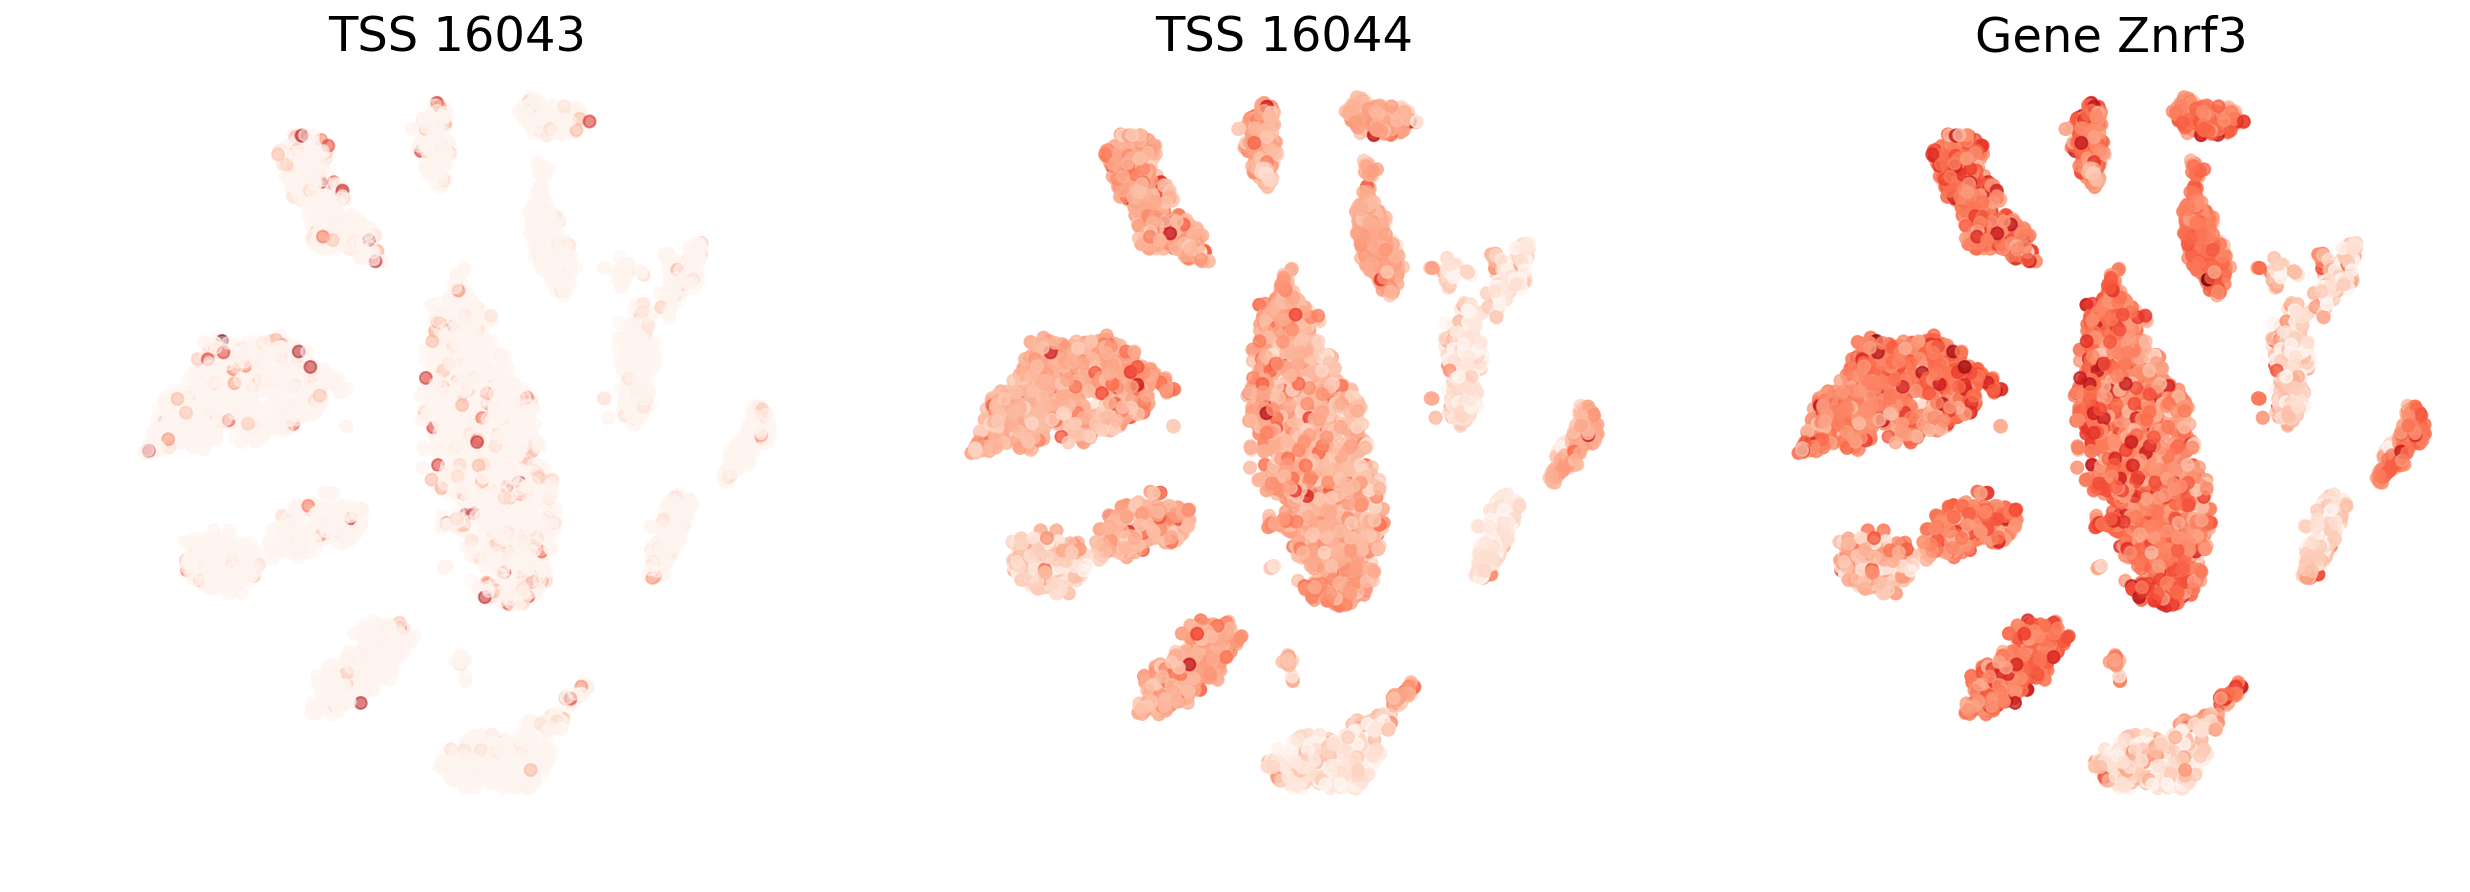

In [127]:
#specific_gene = "Ank3"#Nrgn Rorb

fig, ax = plt.subplots(figsize=(21,7), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
#c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
c = c0
cmap="Reds"
alpha = 0.5

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()
ax[0].set_title("TSS {}".format(tss_class[0]))
####

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = c1
cmap="Reds"
alpha = 0.75

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off() 
ax[1].set_title("TSS {}".format(tss_class[1]))

# ######
x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"]).reshape(-1)
cmap="Reds"
alpha = 0.75

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off() 
ax[2].set_title("Gene {}".format(specific_gene))

plt.show()

# Plot
each cluster is a violin plot, number of TSS is number of violins, 
plot the distribution of that tss within the cluster

26-Feb-20 14:30:56 - update_title_pos
26-Feb-20 14:30:56 - update_title_pos
26-Feb-20 14:30:56 - update_title_pos
26-Feb-20 14:30:56 - update_title_pos


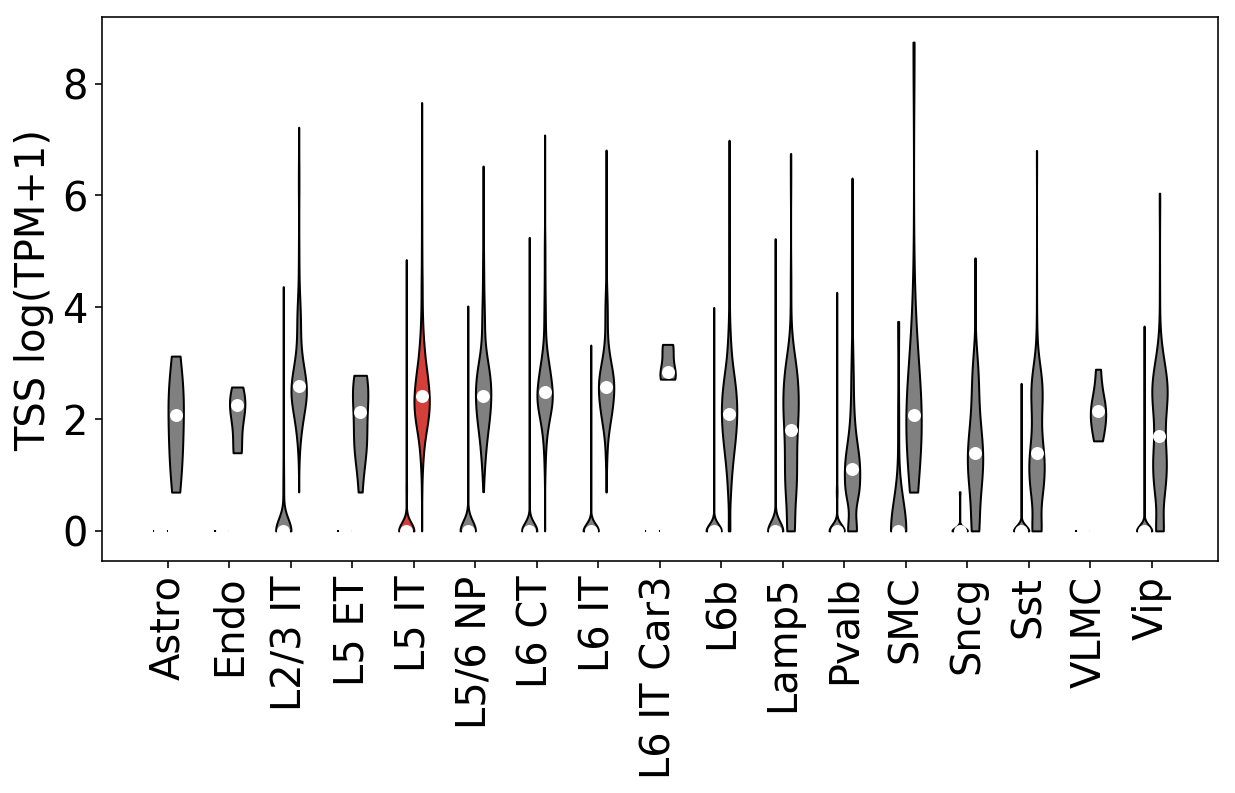

In [128]:
fig, ax = plt.subplots(figsize=(10,5))

unique = np.unique(gene.obs.subclass_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))

midx = np.where(unique==specific_cluster)[0][0]
labels = unique
lidx = np.arange(0.25, len(labels)*2+0.25, 2)
ridx = np.arange(0.75, len(labels)*2 + 0.75, 2)
cidx = np.arange(0.50, len(labels)*2+0.5, 2)

tss_0 = tss_class[0]
tss_1 = tss_class[1]

x = []
y = []
for c in unique:
    x.append(np.asarray(stss[stss.obs.subclass_label==c][:,stss.var.tss_class==tss_0].X).reshape(-1).tolist())
    y.append(np.asarray(stss[stss.obs.subclass_label==c][:,stss.var.tss_class==tss_1].X).reshape(-1).tolist())
    
left = ax.violinplot(x, showmedians=True, showextrema=False, positions=lidx)
right = ax.violinplot(y, showmedians=True, showextrema=False, positions=ridx)
for pcidx, pc in enumerate(left['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')
        
for pcidx, pc in enumerate(right['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')

medians = [np.median(i) for i in x]
ax.scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

medians = [np.median(i) for i in y]
ax.scatter(ridx, medians, marker='o', color='white', s=30, zorder=3)

ax.set_xticks(cidx)
ax.set_xticklabels(labels, rotation=90, ha="center")
ax.set_ylabel("TSS log(TPM+1)")
plt.show()

In [68]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')

def normalize_rows_L1(mat):
    L1 = mat.sum(axis=1)
    norm = mat/L1[:,None]
    return norm

def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def deSS(mtx, components, features, assignments, **kwargs):
    nan_cutoff = kwargs.get("nan_cutoff", 0)
    corr_method = kwargs.get("corr_method", "bonferroni")
    
    unique = np.unique(assignments)
    unique_features = np.unique(features)
    
    nuniq = unique.shape[0]
    nuniq_feat = unique_features.shape[0]
    nfeat = features.shape[0]
    
    pval_bool = np.empty((nuniq, nuniq_feat)).astype(bool)
    pval_bool.fill(False)
    
    for uidx, u in enumerate(unique):
        logging.debug("{} of {} assignments: {}".format(uidx+1, nuniq, u))
        t_mat,c_mat = split_by_target(mtx, assignments, u)

        # now iterate through the TSS classes
        for tidx, t in enumerate(unique_features):
            mask = features == t
            x = t_mat[:,mask]
            y = c_mat[:,mask]
            
            x = normalize_rows_L1(np.asarray(x))
            y = normalize_rows_L1(np.asarray(y))
            
            all_cols_pass_nan =( (np.isnan(x).sum(axis=0)/x.shape[0])>nan_cutoff).sum() == x.shape[1] 
            
            # perform sidak correction and 
            if all_cols_pass_nan:
                test = ttest_ind(x,y, nan_policy="omit")
                if (test.pvalue<0.01).sum()==test.pvalue.shape[0]:
                    pval_bool[uidx, tidx] = True
    
    return pval_bool

In [318]:
# Once we map the transcripts to the isoform matrix, some of them were filtered? so i remove the ones with only 1 count
mask = same.var.TSS_class.map(same.var.groupby("TSS_class")["transcript_id"].count())>1
same = same[:,mask]

In [514]:
tmp1 = same[same.obs.subclass_label == "Vip"]
tmp2 = same[same.obs.subclass_label != "Vip"]

In [480]:
tmp2

View of AnnData object with n_obs × n_vars = 4724 × 124 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'cell_TPM', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'gene_TPM', 'TSS_class'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_pca', 'X_tsne'
    layers: 'X', 'log1p'

In [539]:
%%time
nc = 5
nf = 10

mat         = same.layers["log1p"].todense()[:nc,:nf]
components  = same.obs.cell_id.values[:nc]
features    = same.var.TSS_class.values[:nf]
assignments = same.obs.subclass_label.values[:nc]

z = deSS(mat, components, features, assignments)

19-Feb-20 22:07:07 - 1 of 4 assignments: L5 IT
19-Feb-20 22:07:07 - 2 of 4 assignments: Lamp5
19-Feb-20 22:07:07 - 3 of 4 assignments: Sst
19-Feb-20 22:07:07 - 4 of 4 assignments: Vip


CPU times: user 47 ms, sys: 7.48 ms, total: 54.5 ms
Wall time: 50.2 ms


In [552]:
%%time

mat         = same.layers["log1p"].todense()
components  = same.obs.cell_id.values
features    = same.var.TSS_class.values
assignments = same.obs.subclass_label.values

unique_features = np.unique(features)

z = deSS(mat, components, features, assignments, nan_cutoff=0.5)

19-Feb-20 22:08:36 - 1 of 18 assignments: Astro
19-Feb-20 22:08:36 - 2 of 18 assignments: Endo
19-Feb-20 22:08:36 - 3 of 18 assignments: L2/3 IT
19-Feb-20 22:08:36 - 4 of 18 assignments: L5 ET
19-Feb-20 22:08:36 - 5 of 18 assignments: L5 IT
19-Feb-20 22:08:36 - 6 of 18 assignments: L5/6 NP
19-Feb-20 22:08:37 - 7 of 18 assignments: L6 CT
19-Feb-20 22:08:37 - 8 of 18 assignments: L6 IT
19-Feb-20 22:08:37 - 9 of 18 assignments: L6 IT Car3
19-Feb-20 22:08:37 - 10 of 18 assignments: L6b
19-Feb-20 22:08:37 - 11 of 18 assignments: Lamp5
19-Feb-20 22:08:37 - 12 of 18 assignments: Low Quality
19-Feb-20 22:08:37 - 13 of 18 assignments: Pvalb
19-Feb-20 22:08:37 - 14 of 18 assignments: SMC
19-Feb-20 22:08:37 - 15 of 18 assignments: Sncg
19-Feb-20 22:08:37 - 16 of 18 assignments: Sst
19-Feb-20 22:08:38 - 17 of 18 assignments: VLMC
19-Feb-20 22:08:38 - 18 of 18 assignments: Vip


CPU times: user 1.8 s, sys: 11.1 ms, total: 1.82 s
Wall time: 1.81 s


In [581]:
unique_features[z[-6]]

array([41428])

In [582]:
interesting = 41428

In [589]:
same_t2g[same_t2g["tss_class"] == 41428]

,chromosome,gene_id,new_start,TSS_same,n_TSS_same,transcript_id,tss_class,n_iso
44668,17,ENSMUSG00000090417.3,18277756,"[ENSMUST00000231815.1, ENSMUST00000172190.3, E...",4,ENSMUST00000231815.1,41428,4


In [583]:
same.var[same.var.TSS_class==interesting]

,transcript_id,gene_id,gene_name,transcript_name,gene_TPM,TSS_class
81241,ENSMUST00000231815,ENSMUSG00000090417,Vmn2r94,Vmn2r94-204,8634.106445,41428
81242,ENSMUST00000231390,ENSMUSG00000090417,Vmn2r94,Vmn2r94-202,6814.746094,41428


In [584]:
u = interesting

a = np.asarray(tmp1[:,tmp1.var.TSS_class == u].layers["log1p"].todense())
b = np.asarray(tmp2[:,tmp2.var.TSS_class == u].layers["log1p"].todense())

y = normalize_rows_L1(a)
yy = normalize_rows_L1(b)

y = y[~np.isnan(y[:,0])]
yy = yy[~np.isnan(yy[:,0])]

yerr = sem(y, axis=0)
yyerr = sem(yy, axis=0)

y = y.mean(axis=0)
yy = yy.mean(axis=0)

19-Feb-20 22:11:53 - update_title_pos
19-Feb-20 22:11:53 - update_title_pos
19-Feb-20 22:11:53 - update_title_pos
19-Feb-20 22:11:53 - update_title_pos
19-Feb-20 22:11:53 - update_title_pos


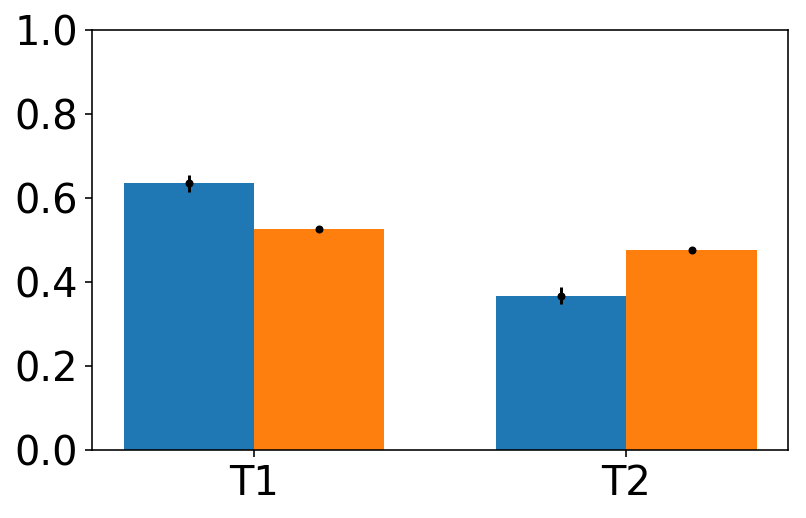

In [586]:
fig, ax = plt.subplots(1, 1, tight_layout=True)

labels = ["T1", "T2"]#, "T3"]

x = np.arange(len(labels))  # the label locations

width = 0.35  # the width of the bars

r1 = ax.bar(x - width/2, y, width, label='Cluster')
r2 = ax.bar(x + width/2, yy, width, label='!Cluster')
ax.errorbar(x- width/2, y, yerr=yerr, fmt='.k');
ax.errorbar(x+ width/2, yy, yerr=yyerr, fmt='.k');

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,1)

plt.show()